In [1]:
# --- Imports ---
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import time
import heapq
from collections import defaultdict, deque
import copy
import json # For potentially saving results

In [2]:


# --- Modified Graph Creation with Scalable Index Pattern ---
def create_dynamic_graph(num_nodes=20, seed=42, connectivity=0.3,
                         busy_node_pattern_interval=5):
    """
    Creates a deterministic random graph with time-varying edge weights,
    assigns node positions, and selects busy nodes based on a consistent
    index interval pattern to ensure scalable distribution.
    """
    if num_nodes <= 0:
        print("Warning: num_nodes must be positive. Returning empty graph.")
        return nx.Graph()

    # Set seeds for reproducibility FOR THIS SPECIFIC GRAPH SIZE
    random.seed(seed)
    np.random.seed(seed)

    # Create a random graph (undirected)
    G = nx.erdos_renyi_graph(n=num_nodes, p=connectivity, seed=seed)

    # --- Ensure Connectivity ---
    max_attempts = num_nodes * 2
    attempts = 0
    # Only try to connect if there's more than one node
    if G.number_of_nodes() > 1:
        while not nx.is_connected(G) and attempts < max_attempts :
            components = list(nx.connected_components(G))
            if len(components) > 1:
                # Connect a random node from a smaller component to the largest one
                largest_component = max(components, key=len)
                other_components = [c for c in components if c != largest_component]
                # Choose a random component that is not the largest
                if not other_components: # Should not happen if len(components)>1, but safety check
                    break
                comp_to_connect = random.choice(other_components)

                u = random.choice(list(largest_component))
                v = random.choice(list(comp_to_connect))
                G.add_edge(u, v)
            # elif G.number_of_edges() == 0: # Handle case of all isolated nodes
            #      node_list = list(G.nodes())
            #      u = random.choice(node_list)
            #      v = random.choice([n for n in node_list if n != u])
            #      if u != v: G.add_edge(u, v)
            #      else: break # Only one node case covered earlier
            else: # Graph has edges but somehow len(components) <= 1 (should be connected)
                 break
            attempts += 1

        if attempts >= max_attempts and not nx.is_connected(G):
             print(f"Warning: Could not ensure graph connectivity for size {num_nodes} after {max_attempts} attempts.")

    # --- Define busy nodes using the scalable index pattern ---
    busy_nodes = []
    if num_nodes > 0 and busy_node_pattern_interval > 0:
        # Select nodes where index modulo interval is 0
        busy_nodes = [i for i in range(num_nodes) if i % busy_node_pattern_interval == 0]
    elif num_nodes > 0:
        print(f"Warning: Invalid busy_node_pattern_interval ({busy_node_pattern_interval}). No busy nodes selected.")

    # --- Assign initial edge weights and dynamic parameters ---
    for u, v in G.edges():
        is_busy_edge = (u in busy_nodes) or (v in busy_nodes)
        # Consistent weight distribution logic
        base_weight = random.uniform(7.0, 10.0) if is_busy_edge else random.uniform(1.0, 4.0)

        G[u][v]['weight'] = base_weight
        G[u][v]['base_weight'] = base_weight
        G[u][v]['variation'] = random.uniform(0.5, 2.5) # Consistent dynamic range
        G[u][v]['period'] = random.uniform(0.05, 0.3)   # Consistent dynamic speed

    # --- Assign node positions ---
    try:
        if G.number_of_nodes() > 50: # Use a potentially faster/better layout for large graphs
            G.pos = nx.kamada_kawai_layout(G)
        elif G.number_of_nodes() > 0:
            G.pos = nx.spring_layout(G, seed=seed) # Spring layout for smaller graphs
        else:
            G.pos = {} # Empty dict for empty graph
    except Exception as e: # Catch any layout error
         print(f"Warning: Layout algorithm failed for size {num_nodes} (seed={seed}, error={e}). Using random layout.")
         G.pos = nx.random_layout(G, seed=seed) if G.nodes else {}

    # Ensure pos attribute exists
    if not hasattr(G, 'pos'):
         G.pos = nx.random_layout(G, seed=seed) if G.nodes else {}

    return G

# --- Graph Utilities ---
def update_edge_weights(G, time_step):
    """Updates edge weights based on time step."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        base = G[u][v].get('base_weight', 5.0)
        variation = G[u][v].get('variation', 1.0)
        period = G[u][v].get('period', 0.2)
        try:
            factor = np.sin(time_step * period) * variation
            G[u][v]['weight'] = max(0.1, base + factor)
        except Exception: G[u][v]['weight'] = base
    return G

def reset_graph_weights(G):
    """Resets edge weights to base values."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        G[u][v]['weight'] = G[u][v].get('base_weight', random.uniform(1, 10))
    return G


In [3]:


# --- D* Lite Implementation ---
# <<< Keep the corrected DStarLite class from the previous answer here >>>
class DStarLite:
    # --- D* Lite Code (Exactly as in the previous corrected version) ---
    def __init__(self, graph, start, goal):
        self.G = graph # Should be a NetworkX Graph (undirected assumed)
        self.start = start
        self.goal = goal
        self.current = start # Agent's current position

        self.U = [] # Priority queue (min-heap)
        self.g = defaultdict(lambda: float('inf'))
        self.rhs = defaultdict(lambda: float('inf'))
        self.km = 0 # Key modifier for heuristic updates

        self.rhs[goal] = 0
        try:
            initial_key = self.calculate_key(goal)
            if not isinstance(initial_key, tuple) or len(initial_key) != 2:
                raise TypeError(f"Initial key for goal {goal} is not a valid tuple: {initial_key}")
            heapq.heappush(self.U, (initial_key, goal))
        except TypeError as e:
             print(f"Error pushing initial goal node {goal} to heap: {e}")
             print(f"Goal key calculation resulted in: {self.calculate_key(goal)}")
             raise

    def calculate_key(self, node):
        """Calculate the key for a node in the priority queue"""
        g_val = self.g[node]
        rhs_val = self.rhs[node]
        min_g_rhs = min(g_val, rhs_val)

        h_cost = self.heuristic(self.start, node)
        if not isinstance(h_cost, (int, float)): h_cost = 0
        return (min_g_rhs + h_cost + self.km, min_g_rhs)

    def heuristic(self, a, b):
        """Heuristic function (Euclidean distance if positions exist)"""
        if a not in self.G or b not in self.G: return 0
        if not hasattr(self.G, 'pos') or not self.G.pos: return 0
        if a not in self.G.pos or b not in self.G.pos: return 0
        pos_a, pos_b = self.G.pos[a], self.G.pos[b]
        if (isinstance(pos_a, (list, tuple)) and len(pos_a) >= 2 and
            isinstance(pos_b, (list, tuple)) and len(pos_b) >= 2 and
            all(isinstance(coord, (int, float)) for coord in pos_a[:2] + pos_b[:2])):
             try: return math.sqrt((pos_a[0] - pos_b[0])**2 + (pos_a[1] - pos_b[1])**2)
             except (TypeError, ValueError): return 0
        return 0

    def update_vertex(self, u):
        """Update the RHS value and priority queue entry for a vertex"""
        if u != self.goal:
            min_rhs = float('inf')
            for v in self.G.neighbors(u):
                 cost = self.get_edge_cost(u, v)
                 if cost != float('inf') and self.g[v] != float('inf'):
                     min_rhs = min(min_rhs, cost + self.g[v])
            self.rhs[u] = min_rhs

        in_queue = any(node == u for _, node in self.U)
        if in_queue:
            self.U = [(key, node) for key, node in self.U if node != u]
            heapq.heapify(self.U)

        if self.g[u] != self.rhs[u]:
            try:
                 key_u = self.calculate_key(u)
                 if not isinstance(key_u, tuple) or len(key_u) != 2: raise TypeError(f"Invalid key: {key_u}")
                 heapq.heappush(self.U, (key_u, u))
            except TypeError as e:
                 print(f"Error pushing node {u} during update: {e}, Key: {self.calculate_key(u)}")

    def get_edge_cost(self, u, v):
         """Safely get edge cost."""
         if self.G.has_edge(u, v):
             weight = self.G[u][v].get('weight', float('inf'))
             return weight if isinstance(weight, (int, float)) else float('inf')
         return float('inf')

    def compute_shortest_path(self):
        """Compute shortest path values."""
        max_compute_steps = self.G.number_of_nodes() * self.G.number_of_edges() * 2
        compute_steps = 0
        while self.U and (self.U[0][0] < self.calculate_key(self.start) or self.rhs[self.start] != self.g[self.start]):
            compute_steps += 1
            if compute_steps > max_compute_steps:
                 print(f"Warning: Exceeded D* compute step limit ({max_compute_steps}).")
                 break
            try: k_old, u = heapq.heappop(self.U)
            except IndexError: break
            k_new = self.calculate_key(u)
            if k_old < k_new:
                try: heapq.heappush(self.U, (k_new, u))
                except TypeError as e: print(f"Error pushing {u} (key increased): {e}")
            elif self.g[u] > self.rhs[u]:
                self.g[u] = self.rhs[u]
                for s in self.G.neighbors(u): self.update_vertex(s)
            else:
                g_old = self.g[u]
                self.g[u] = float('inf')
                affected_nodes = list(self.G.neighbors(u)) + [u]
                for s in affected_nodes: self.update_vertex(s)
            if len(self.U) > self.G.number_of_nodes() * 5:
                print(f"Warning: D* queue size potentially excessive ({len(self.U)}).")

    def get_next_node(self):
        """Get the best next node."""
        if self.current == self.goal: return None
        min_cost_plus_g, next_node = float('inf'), None
        for neighbor in self.G.neighbors(self.current):
            cost, g_neighbor = self.get_edge_cost(self.current, neighbor), self.g[neighbor]
            if cost == float('inf') or g_neighbor == float('inf'): continue
            current_cost_plus_g = cost + g_neighbor
            if current_cost_plus_g < min_cost_plus_g:
                min_cost_plus_g, next_node = current_cost_plus_g, neighbor
            elif current_cost_plus_g == min_cost_plus_g and next_node is not None:
                 h_neighbor, h_next_node = self.heuristic(neighbor, self.goal), self.heuristic(next_node, self.goal)
                 if h_neighbor < h_next_node or (h_neighbor == h_next_node and neighbor < next_node):
                      next_node = neighbor
        return next_node

    def move_to(self, node):
        """Update agent's current position."""
        if node is not None and node != self.current:
            self.current = node
            self.start = node

    def notify_edge_changes(self, changed_edges):
        """Notify D* about edge changes."""
        nodes_to_update = set(n for edge in changed_edges for n in edge)
        for node in nodes_to_update: self.update_vertex(node)
        self.compute_shortest_path()

In [4]:

# --- D* Lite Navigation Function ---
def navigate_with_dstar(graph_instance, start_node, goal_node, max_steps=None):
    """Navigate using D* Lite, handling dynamic weights during navigation."""
    print(f"\n--- D* Lite Navigation: {start_node} -> {goal_node} (Size: {graph_instance.number_of_nodes()}) ---")
    G_nav = graph_instance
    if start_node not in G_nav or goal_node not in G_nav:
        print(f"Error: Start/Goal node not in graph."); return [], float('inf'), 0, 0.0
    reset_graph_weights(G_nav)
    try: planner = DStarLite(G_nav, start_node, goal_node)
    except Exception as e: print(f"Error initializing D*: {e}"); return [], float('inf'), 0, 0.0

    current_node, current_time, total_cost = start_node, 0, 0.0
    path = [current_node]
    if max_steps is None: max_steps = G_nav.number_of_nodes() * 2

    start_time_exec = time.perf_counter()
    try: planner.compute_shortest_path()
    except Exception as e:
        print(f"Error during initial D* compute: {e}"); end_time_exec = time.perf_counter()
        return [], float('inf'), 0, end_time_exec - start_time_exec
    if planner.g[start_node] == float('inf'):
         print("D* Lite: Initial path failed (g[start]=inf)."); end_time_exec = time.perf_counter()
         return [], float('inf'), 0, end_time_exec - start_time_exec

    while current_node != goal_node and current_time < max_steps:
        update_edge_weights(G_nav, current_time)
        changed_edges = list(G_nav.edges())
        try: planner.notify_edge_changes(changed_edges)
        except Exception as e: print(f"Error during D* notify/recompute at t={current_time}: {e}"); total_cost=float('inf'); break
        next_node = planner.get_next_node()
        if next_node is None:
            if current_node == goal_node: break
            print(f"D* Lite: No path from {current_node} at t={current_time}."); total_cost = float('inf'); break
        edge_cost = planner.get_edge_cost(current_node, next_node)
        if edge_cost == float('inf'):
             print(f"D* Error: Planned edge ({current_node},{next_node}) infinite cost t={current_time}!"); total_cost = float('inf'); break
        total_cost += edge_cost
        planner.move_to(next_node)
        current_node = next_node
        path.append(current_node)
        current_time += 1

    end_time_exec = time.perf_counter()
    elapsed_time = end_time_exec - start_time_exec
    success = (current_node == goal_node and total_cost != float('inf'))

    print(f"D* Lite: {'Reached goal' if success else ('Max steps' if current_time >= max_steps else 'Failed')}.")
    if success: print(f"  Path: {path}, Cost: {total_cost:.2f}, Steps: {current_time}, Time: {elapsed_time:.4f}s")
    elif path: print(f"  Partial Path: {path}, Final Cost: {total_cost:.2f}")

    return path if success else [], total_cost if success else float('inf'), current_time, elapsed_time

In [5]:


# --- Q-Learning Implementation ---
class QLearningPathFinder:
    # --- Q-Learning Code  ---
    def __init__(self, graph, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.05):
        self.G_template = graph # Store the template graph structure/params
        self.nodes = list(graph.nodes()) if graph else []
        self.num_nodes = len(self.nodes)
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.min_epsilon = min_exploration_rate
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.experience = deque(maxlen=10000)
        self.positions = getattr(self.G_template, 'pos', None)

    def get_state(self, current_node, goal_node): return (current_node, goal_node)

    def choose_action(self, state, available_actions, is_training=True):
        if not available_actions: return None
        if is_training and random.random() < self.epsilon: return random.choice(available_actions)
        q_values = self.q_table[state]
        best_q_value = -float('inf')
        best_actions = []
        for action_node in available_actions:
            q_val = q_values[action_node]
            if q_val > best_q_value: best_q_value, best_actions = q_val, [action_node]
            elif q_val == best_q_value: best_actions.append(action_node)
        return random.choice(best_actions) if best_actions else (random.choice(available_actions) if available_actions else None)

    def _heuristic_distance(self, node1, node2):
        if not self.positions or node1 not in self.positions or node2 not in self.positions: return None
        pos1, pos2 = self.positions[node1], self.positions[node2]
        if (isinstance(pos1,(list,tuple)) and len(pos1)>=2 and isinstance(pos2,(list,tuple)) and len(pos2)>=2 and
            all(isinstance(c,(int,float)) for c in pos1[:2]+pos2[:2])):
            try: return math.sqrt((pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)
            except (TypeError, ValueError): return None
        return None

    def calculate_reward(self, G_instance, current_node, next_node, goal_node):
        if not G_instance.has_edge(current_node, next_node): return -100.0
        edge_weight = G_instance[current_node][next_node].get('weight', 100.0)
        if not isinstance(edge_weight,(int, float)): edge_weight = 100.0
        reward = -edge_weight
        if next_node == goal_node: reward += 100.0
        return reward

    def update_q_value(self, state, action, reward, next_state, available_next_actions):
        max_next_q = 0.0
        if available_next_actions:
            next_q_values = self.q_table[next_state]
            max_next_q = max((next_q_values[na] for na in available_next_actions), default=0.0)
        current_q = self.q_table[state][action]
        self.q_table[state][action] = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)

    def experience_replay(self, batch_size=32):
        if len(self.experience) < batch_size: return
        mini_batch = random.sample(self.experience, batch_size)
        for state, action, reward, next_state, available_next_actions in mini_batch:
            self.update_q_value(state, action, reward, next_state, available_next_actions)

    def train(self, num_episodes=5000, max_steps_per_episode=100, experience_replay_batch_size=32):
        print(f"\n--- Starting QL Training (Size: {self.num_nodes}, Episodes: {num_episodes}) ---")
        stats = {'episode_rewards': [], 'episode_steps': []}
        if self.num_nodes < 2: print("Warning: Too few nodes. Skipping training."); return stats
        G_train = self.G_template.copy()
        if hasattr(self.G_template, 'pos'): G_train.pos = self.G_template.pos
        start_train_time = time.perf_counter()
        nodes = list(self.nodes)

        for ep in range(num_episodes):
            start, goal = random.sample(nodes, 2)
            curr, t_reward, t = start, 0.0, 0
            reset_graph_weights(G_train)

            for step in range(max_steps_per_episode):
                update_edge_weights(G_train, t)
                state = self.get_state(curr, goal)
                actions = list(G_train.neighbors(curr))
                if not actions: break
                action = self.choose_action(state, actions, is_training=True)
                if action is None: break
                reward = self.calculate_reward(G_train, curr, action, goal)
                t_reward += reward
                next_node = action
                next_state = self.get_state(next_node, goal)
                next_actions = list(G_train.neighbors(next_node))
                self.experience.append((state, action, reward, next_state, next_actions))
                if len(self.experience) > experience_replay_batch_size: self.experience_replay(experience_replay_batch_size)
                curr = next_node
                t += 1
                if curr == goal: break

            stats['episode_rewards'].append(t_reward)
            stats['episode_steps'].append(step + 1)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            if (ep + 1) % (num_episodes // 10 or 500) == 0: # Print progress ~10 times
                 if len(stats['episode_rewards']) >= 100:
                    avg_r = np.mean(stats['episode_rewards'][-100:])
                    avg_s = np.mean(stats['episode_steps'][-100:])
                    print(f"  Ep {ep+1}/{num_episodes} | Avg R(100): {avg_r:.2f} | Avg S(100): {avg_s:.1f} | Eps: {self.epsilon:.3f}")
                 else: print(f"  Ep {ep+1}/{num_episodes} | Eps: {self.epsilon:.3f}")

        print(f"--- QL Training Finished in {time.perf_counter() - start_train_time:.2f}s ---")
        return stats


Streaming output truncated to the last 5000 lines.
  Ep 20000/20000 | Avg R(100): 90.37 | Avg S(100): 2.4 | Eps: 0.050
--- QL Training Finished in 105.48s ---

Running benchmark for size 50...

--- Running Benchmark (Size: 50, Pairs: 50) ---

===== Test Pair 1/50: 1 -> 28 (Size: 50) =====

--- D* Lite Navigation: 1 -> 28 (Size: 50) ---
D* Lite: Reached goal.
  Path: [1, 38, 17, 28], Cost: 5.46, Steps: 3, Time: 0.0273s

--- QL Policy Execution: 1 -> 28 (Size: 50) ---
QL Policy: Reached goal.
  Path: [1, 13, 28], Cost: 6.82, Steps: 2, Time: 0.0017s
--------------------
D* Success: True, Cost: 5.46, Time: 0.0273
QL Success: True, Cost: 6.82, Time: 0.0017
Cost Ratio (QL/D*): 1.249
Step Ratio (QL/D*): 0.667
Time Ratio (QL Decision / D* Total): 0.061

===== Test Pair 2/50: 11 -> 42 (Size: 50) =====

--- D* Lite Navigation: 11 -> 42 (Size: 50) ---
D* Lite: Reached goal.
  Path: [11, 14, 42], Cost: 3.77, Steps: 2, Time: 0.0113s

--- QL Policy Execution: 11 -> 42 (Size: 50) ---
QL Policy: Reach

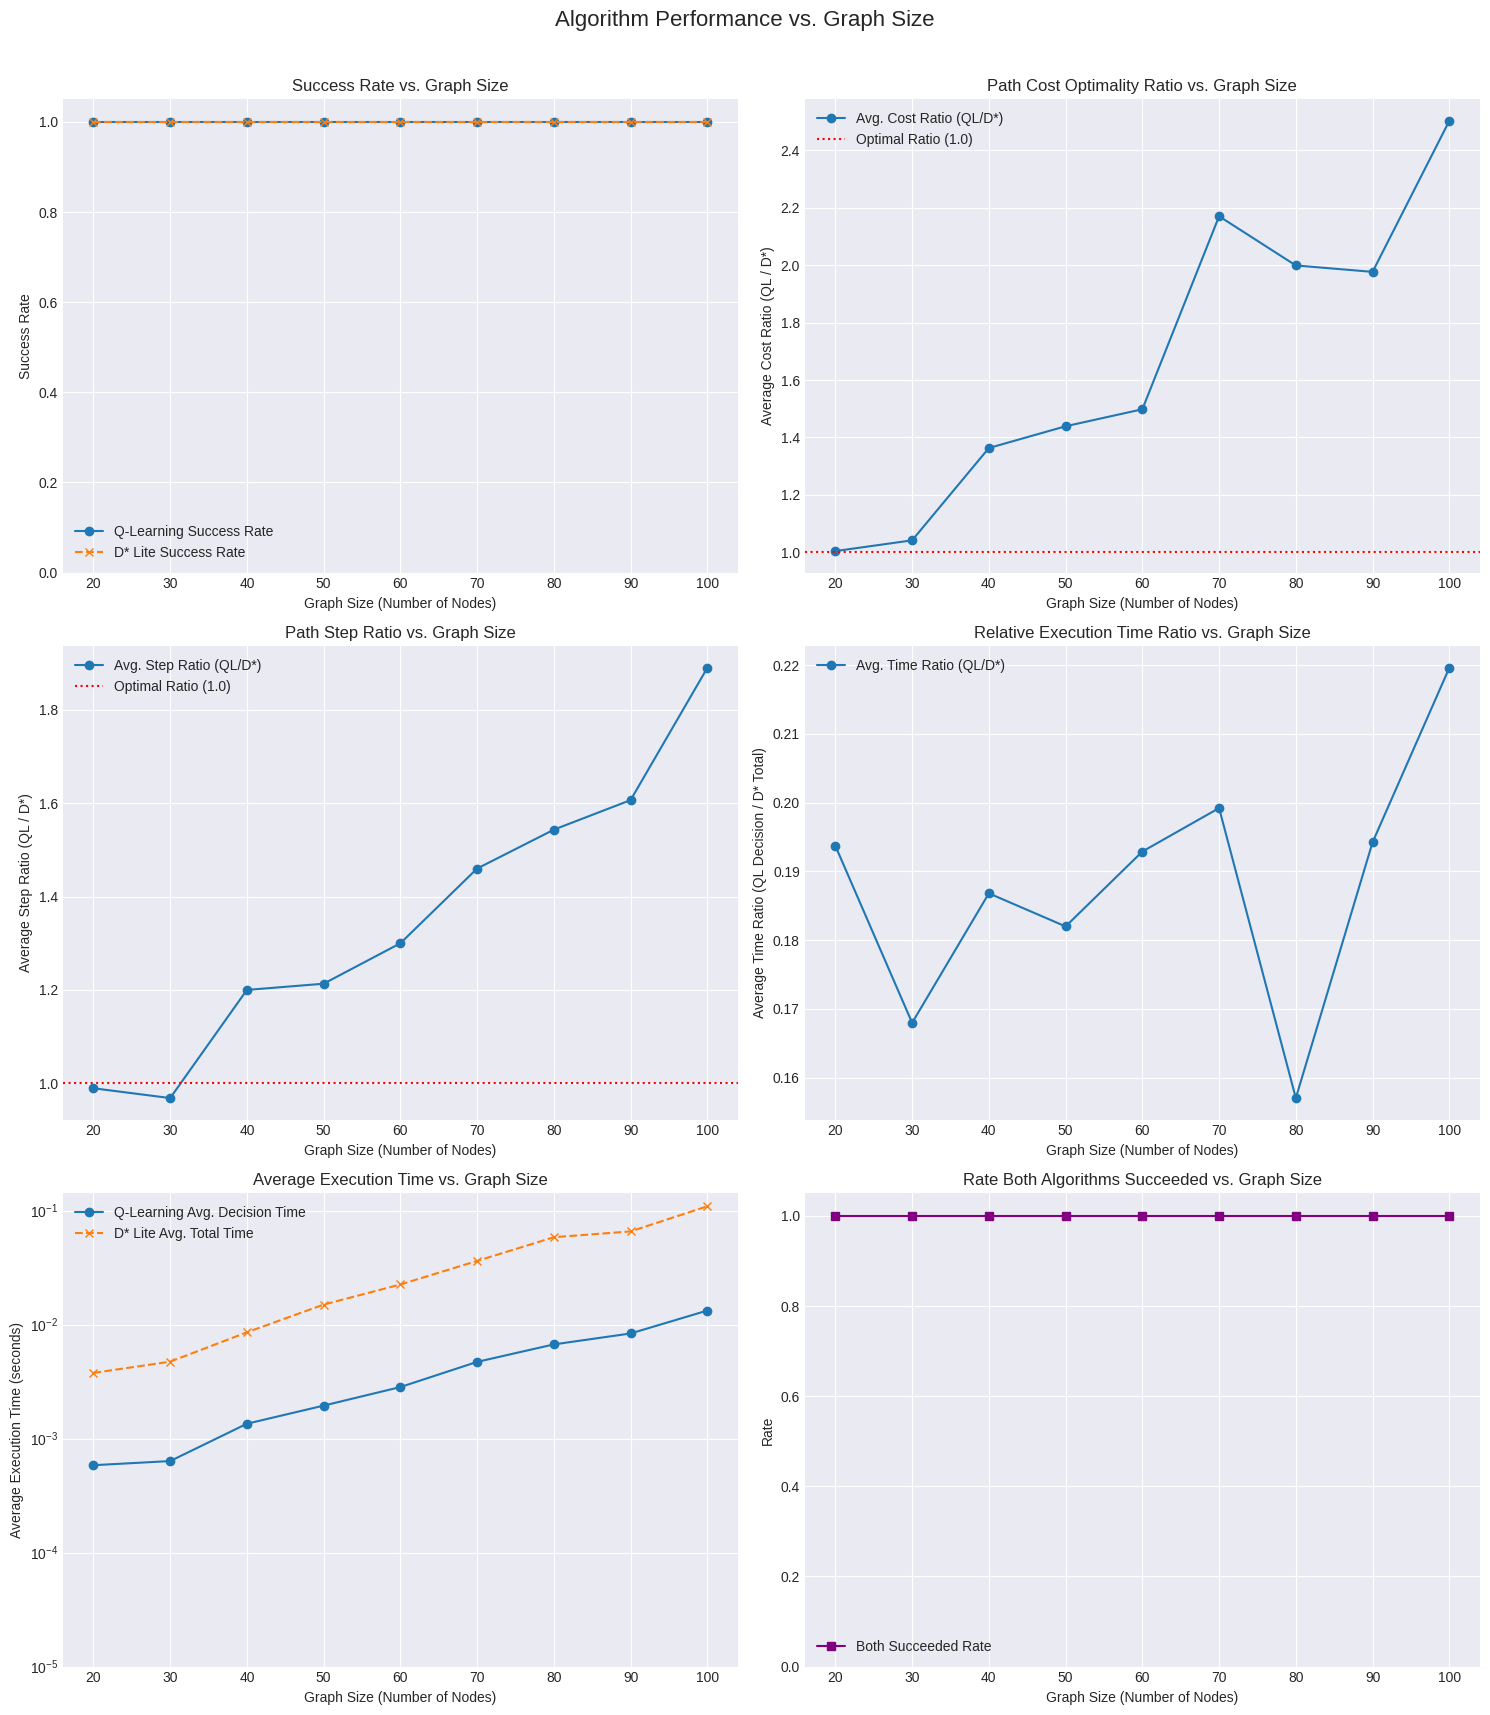


--- Experiment Finished ---


In [6]:
# --- Imports ---
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import time
import heapq
from collections import defaultdict, deque
import copy
import json # For potentially saving results

# --- Modified Graph Creation with Scalable Index Pattern ---
def create_dynamic_graph(num_nodes=20, seed=42, connectivity=0.3,
                         busy_node_pattern_interval=5):
    """
    Creates a deterministic random graph with time-varying edge weights,
    assigns node positions, and selects busy nodes based on a consistent
    index interval pattern to ensure scalable distribution.
    """
    if num_nodes <= 0:
        print("Warning: num_nodes must be positive. Returning empty graph.")
        return nx.Graph()

    # Set seeds for reproducibility FOR THIS SPECIFIC GRAPH SIZE
    random.seed(seed)
    np.random.seed(seed)

    # Create a random graph (undirected)
    G = nx.erdos_renyi_graph(n=num_nodes, p=connectivity, seed=seed)

    # --- Ensure Connectivity ---
    max_attempts = num_nodes * 2
    attempts = 0
    # Only try to connect if there's more than one node
    if G.number_of_nodes() > 1:
        while not nx.is_connected(G) and attempts < max_attempts :
            components = list(nx.connected_components(G))
            if len(components) > 1:
                # Connect a random node from a smaller component to the largest one
                largest_component = max(components, key=len)
                other_components = [c for c in components if c != largest_component]
                # Choose a random component that is not the largest
                if not other_components: # Should not happen if len(components)>1, but safety check
                    break
                comp_to_connect = random.choice(other_components)

                u = random.choice(list(largest_component))
                v = random.choice(list(comp_to_connect))
                G.add_edge(u, v)
            # elif G.number_of_edges() == 0: # Handle case of all isolated nodes
            #      node_list = list(G.nodes())
            #      u = random.choice(node_list)
            #      v = random.choice([n for n in node_list if n != u])
            #      if u != v: G.add_edge(u, v)
            #      else: break # Only one node case covered earlier
            else: # Graph has edges but somehow len(components) <= 1 (should be connected)
                 break
            attempts += 1

        if attempts >= max_attempts and not nx.is_connected(G):
             print(f"Warning: Could not ensure graph connectivity for size {num_nodes} after {max_attempts} attempts.")

    # --- Define busy nodes using the scalable index pattern ---
    busy_nodes = []
    if num_nodes > 0 and busy_node_pattern_interval > 0:
        # Select nodes where index modulo interval is 0
        busy_nodes = [i for i in range(num_nodes) if i % busy_node_pattern_interval == 0]
    elif num_nodes > 0:
        print(f"Warning: Invalid busy_node_pattern_interval ({busy_node_pattern_interval}). No busy nodes selected.")

    # --- Assign initial edge weights and dynamic parameters ---
    for u, v in G.edges():
        is_busy_edge = (u in busy_nodes) or (v in busy_nodes)
        # Consistent weight distribution logic
        base_weight = random.uniform(7.0, 10.0) if is_busy_edge else random.uniform(1.0, 4.0)

        G[u][v]['weight'] = base_weight
        G[u][v]['base_weight'] = base_weight
        G[u][v]['variation'] = random.uniform(0.5, 2.5) # Consistent dynamic range
        G[u][v]['period'] = random.uniform(0.05, 0.3)   # Consistent dynamic speed

    # --- Assign node positions ---
    try:
        if G.number_of_nodes() > 50: # Use a potentially faster/better layout for large graphs
            G.pos = nx.kamada_kawai_layout(G)
        elif G.number_of_nodes() > 0:
            G.pos = nx.spring_layout(G, seed=seed) # Spring layout for smaller graphs
        else:
            G.pos = {} # Empty dict for empty graph
    except Exception as e: # Catch any layout error
         print(f"Warning: Layout algorithm failed for size {num_nodes} (seed={seed}, error={e}). Using random layout.")
         G.pos = nx.random_layout(G, seed=seed) if G.nodes else {}

    # Ensure pos attribute exists
    if not hasattr(G, 'pos'):
         G.pos = nx.random_layout(G, seed=seed) if G.nodes else {}

    return G


# --- Graph Utilities ---
def update_edge_weights(G, time_step):
    """Updates edge weights based on time step."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        base = G[u][v].get('base_weight', 5.0)
        variation = G[u][v].get('variation', 1.0)
        period = G[u][v].get('period', 0.2)
        try:
            factor = np.sin(time_step * period) * variation
            G[u][v]['weight'] = max(0.1, base + factor)
        except Exception: G[u][v]['weight'] = base
    return G

def reset_graph_weights(G):
    """Resets edge weights to base values."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        G[u][v]['weight'] = G[u][v].get('base_weight', random.uniform(1, 10))
    return G

# --- D* Lite Implementation ---
# <<< Keep the corrected DStarLite class from the previous answer here >>>
class DStarLite:
    # --- D* Lite Code (Exactly as in the previous corrected version) ---
    def __init__(self, graph, start, goal):
        self.G = graph # Should be a NetworkX Graph (undirected assumed)
        self.start = start
        self.goal = goal
        self.current = start # Agent's current position

        self.U = [] # Priority queue (min-heap)
        self.g = defaultdict(lambda: float('inf'))
        self.rhs = defaultdict(lambda: float('inf'))
        self.km = 0 # Key modifier for heuristic updates

        self.rhs[goal] = 0
        try:
            initial_key = self.calculate_key(goal)
            if not isinstance(initial_key, tuple) or len(initial_key) != 2:
                raise TypeError(f"Initial key for goal {goal} is not a valid tuple: {initial_key}")
            heapq.heappush(self.U, (initial_key, goal))
        except TypeError as e:
             print(f"Error pushing initial goal node {goal} to heap: {e}")
             print(f"Goal key calculation resulted in: {self.calculate_key(goal)}")
             raise

    def calculate_key(self, node):
        """Calculate the key for a node in the priority queue"""
        g_val = self.g[node]
        rhs_val = self.rhs[node]
        min_g_rhs = min(g_val, rhs_val)

        h_cost = self.heuristic(self.start, node)
        if not isinstance(h_cost, (int, float)): h_cost = 0
        return (min_g_rhs + h_cost + self.km, min_g_rhs)

    def heuristic(self, a, b):
        """Heuristic function (Euclidean distance if positions exist)"""
        if a not in self.G or b not in self.G: return 0
        if not hasattr(self.G, 'pos') or not self.G.pos: return 0
        if a not in self.G.pos or b not in self.G.pos: return 0
        pos_a, pos_b = self.G.pos[a], self.G.pos[b]
        if (isinstance(pos_a, (list, tuple)) and len(pos_a) >= 2 and
            isinstance(pos_b, (list, tuple)) and len(pos_b) >= 2 and
            all(isinstance(coord, (int, float)) for coord in pos_a[:2] + pos_b[:2])):
             try: return math.sqrt((pos_a[0] - pos_b[0])**2 + (pos_a[1] - pos_b[1])**2)
             except (TypeError, ValueError): return 0
        return 0

    def update_vertex(self, u):
        """Update the RHS value and priority queue entry for a vertex"""
        if u != self.goal:
            min_rhs = float('inf')
            for v in self.G.neighbors(u):
                 cost = self.get_edge_cost(u, v)
                 if cost != float('inf') and self.g[v] != float('inf'):
                     min_rhs = min(min_rhs, cost + self.g[v])
            self.rhs[u] = min_rhs

        in_queue = any(node == u for _, node in self.U)
        if in_queue:
            self.U = [(key, node) for key, node in self.U if node != u]
            heapq.heapify(self.U)

        if self.g[u] != self.rhs[u]:
            try:
                 key_u = self.calculate_key(u)
                 if not isinstance(key_u, tuple) or len(key_u) != 2: raise TypeError(f"Invalid key: {key_u}")
                 heapq.heappush(self.U, (key_u, u))
            except TypeError as e:
                 print(f"Error pushing node {u} during update: {e}, Key: {self.calculate_key(u)}")

    def get_edge_cost(self, u, v):
         """Safely get edge cost."""
         if self.G.has_edge(u, v):
             weight = self.G[u][v].get('weight', float('inf'))
             return weight if isinstance(weight, (int, float)) else float('inf')
         return float('inf')

    def compute_shortest_path(self):
        """Compute shortest path values."""
        max_compute_steps = self.G.number_of_nodes() * self.G.number_of_edges() * 2
        compute_steps = 0
        while self.U and (self.U[0][0] < self.calculate_key(self.start) or self.rhs[self.start] != self.g[self.start]):
            compute_steps += 1
            if compute_steps > max_compute_steps:
                 print(f"Warning: Exceeded D* compute step limit ({max_compute_steps}).")
                 break
            try: k_old, u = heapq.heappop(self.U)
            except IndexError: break
            k_new = self.calculate_key(u)
            if k_old < k_new:
                try: heapq.heappush(self.U, (k_new, u))
                except TypeError as e: print(f"Error pushing {u} (key increased): {e}")
            elif self.g[u] > self.rhs[u]:
                self.g[u] = self.rhs[u]
                for s in self.G.neighbors(u): self.update_vertex(s)
            else:
                g_old = self.g[u]
                self.g[u] = float('inf')
                affected_nodes = list(self.G.neighbors(u)) + [u]
                for s in affected_nodes: self.update_vertex(s)
            if len(self.U) > self.G.number_of_nodes() * 5:
                print(f"Warning: D* queue size potentially excessive ({len(self.U)}).")

    def get_next_node(self):
        """Get the best next node."""
        if self.current == self.goal: return None
        min_cost_plus_g, next_node = float('inf'), None
        for neighbor in self.G.neighbors(self.current):
            cost, g_neighbor = self.get_edge_cost(self.current, neighbor), self.g[neighbor]
            if cost == float('inf') or g_neighbor == float('inf'): continue
            current_cost_plus_g = cost + g_neighbor
            if current_cost_plus_g < min_cost_plus_g:
                min_cost_plus_g, next_node = current_cost_plus_g, neighbor
            elif current_cost_plus_g == min_cost_plus_g and next_node is not None:
                 h_neighbor, h_next_node = self.heuristic(neighbor, self.goal), self.heuristic(next_node, self.goal)
                 if h_neighbor < h_next_node or (h_neighbor == h_next_node and neighbor < next_node):
                      next_node = neighbor
        return next_node

    def move_to(self, node):
        """Update agent's current position."""
        if node is not None and node != self.current:
            self.current = node
            self.start = node

    def notify_edge_changes(self, changed_edges):
        """Notify D* about edge changes."""
        nodes_to_update = set(n for edge in changed_edges for n in edge)
        for node in nodes_to_update: self.update_vertex(node)
        self.compute_shortest_path()
# --- D* Lite Navigation Function ---
# <<< Keep navigate_with_dstar function from the previous answer here >>>
def navigate_with_dstar(graph_instance, start_node, goal_node, max_steps=None):
    """Navigate using D* Lite, handling dynamic weights during navigation."""
    print(f"\n--- D* Lite Navigation: {start_node} -> {goal_node} (Size: {graph_instance.number_of_nodes()}) ---")
    G_nav = graph_instance
    if start_node not in G_nav or goal_node not in G_nav:
        print(f"Error: Start/Goal node not in graph."); return [], float('inf'), 0, 0.0
    reset_graph_weights(G_nav)
    try: planner = DStarLite(G_nav, start_node, goal_node)
    except Exception as e: print(f"Error initializing D*: {e}"); return [], float('inf'), 0, 0.0

    current_node, current_time, total_cost = start_node, 0, 0.0
    path = [current_node]
    if max_steps is None: max_steps = G_nav.number_of_nodes() * 2

    start_time_exec = time.perf_counter()
    try: planner.compute_shortest_path()
    except Exception as e:
        print(f"Error during initial D* compute: {e}"); end_time_exec = time.perf_counter()
        return [], float('inf'), 0, end_time_exec - start_time_exec
    if planner.g[start_node] == float('inf'):
         print("D* Lite: Initial path failed (g[start]=inf)."); end_time_exec = time.perf_counter()
         return [], float('inf'), 0, end_time_exec - start_time_exec

    while current_node != goal_node and current_time < max_steps:
        update_edge_weights(G_nav, current_time)
        changed_edges = list(G_nav.edges())
        try: planner.notify_edge_changes(changed_edges)
        except Exception as e: print(f"Error during D* notify/recompute at t={current_time}: {e}"); total_cost=float('inf'); break
        next_node = planner.get_next_node()
        if next_node is None:
            if current_node == goal_node: break
            print(f"D* Lite: No path from {current_node} at t={current_time}."); total_cost = float('inf'); break
        edge_cost = planner.get_edge_cost(current_node, next_node)
        if edge_cost == float('inf'):
             print(f"D* Error: Planned edge ({current_node},{next_node}) infinite cost t={current_time}!"); total_cost = float('inf'); break
        total_cost += edge_cost
        planner.move_to(next_node)
        current_node = next_node
        path.append(current_node)
        current_time += 1

    end_time_exec = time.perf_counter()
    elapsed_time = end_time_exec - start_time_exec
    success = (current_node == goal_node and total_cost != float('inf'))

    print(f"D* Lite: {'Reached goal' if success else ('Max steps' if current_time >= max_steps else 'Failed')}.")
    if success: print(f"  Path: {path}, Cost: {total_cost:.2f}, Steps: {current_time}, Time: {elapsed_time:.4f}s")
    elif path: print(f"  Partial Path: {path}, Final Cost: {total_cost:.2f}")

    return path if success else [], total_cost if success else float('inf'), current_time, elapsed_time


# --- Q-Learning Implementation ---
# <<< Keep QLearningPathFinder class from the previous answer here >>>
class QLearningPathFinder:
    # --- Q-Learning Code (Exactly as in the previous corrected version) ---
    def __init__(self, graph, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.05):
        self.G_template = graph # Store the template graph structure/params
        self.nodes = list(graph.nodes()) if graph else []
        self.num_nodes = len(self.nodes)
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.min_epsilon = min_exploration_rate
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.experience = deque(maxlen=10000)
        self.positions = getattr(self.G_template, 'pos', None)

    def get_state(self, current_node, goal_node): return (current_node, goal_node)

    def choose_action(self, state, available_actions, is_training=True):
        if not available_actions: return None
        if is_training and random.random() < self.epsilon: return random.choice(available_actions)
        q_values = self.q_table[state]
        best_q_value = -float('inf')
        best_actions = []
        for action_node in available_actions:
            q_val = q_values[action_node]
            if q_val > best_q_value: best_q_value, best_actions = q_val, [action_node]
            elif q_val == best_q_value: best_actions.append(action_node)
        return random.choice(best_actions) if best_actions else (random.choice(available_actions) if available_actions else None)

    def _heuristic_distance(self, node1, node2):
        if not self.positions or node1 not in self.positions or node2 not in self.positions: return None
        pos1, pos2 = self.positions[node1], self.positions[node2]
        if (isinstance(pos1,(list,tuple)) and len(pos1)>=2 and isinstance(pos2,(list,tuple)) and len(pos2)>=2 and
            all(isinstance(c,(int,float)) for c in pos1[:2]+pos2[:2])):
            try: return math.sqrt((pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)
            except (TypeError, ValueError): return None
        return None

    def calculate_reward(self, G_instance, current_node, next_node, goal_node):
        if not G_instance.has_edge(current_node, next_node): return -100.0
        edge_weight = G_instance[current_node][next_node].get('weight', 100.0)
        if not isinstance(edge_weight,(int, float)): edge_weight = 100.0
        reward = -edge_weight
        if next_node == goal_node: reward += 100.0
        return reward

    def update_q_value(self, state, action, reward, next_state, available_next_actions):
        max_next_q = 0.0
        if available_next_actions:
            next_q_values = self.q_table[next_state]
            max_next_q = max((next_q_values[na] for na in available_next_actions), default=0.0)
        current_q = self.q_table[state][action]
        self.q_table[state][action] = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)

    def experience_replay(self, batch_size=32):
        if len(self.experience) < batch_size: return
        mini_batch = random.sample(self.experience, batch_size)
        for state, action, reward, next_state, available_next_actions in mini_batch:
            self.update_q_value(state, action, reward, next_state, available_next_actions)

    def train(self, num_episodes=5000, max_steps_per_episode=100, experience_replay_batch_size=32):
        print(f"\n--- Starting QL Training (Size: {self.num_nodes}, Episodes: {num_episodes}) ---")
        stats = {'episode_rewards': [], 'episode_steps': []}
        if self.num_nodes < 2: print("Warning: Too few nodes. Skipping training."); return stats
        G_train = self.G_template.copy()
        if hasattr(self.G_template, 'pos'): G_train.pos = self.G_template.pos
        start_train_time = time.perf_counter()
        nodes = list(self.nodes)

        for ep in range(num_episodes):
            start, goal = random.sample(nodes, 2)
            curr, t_reward, t = start, 0.0, 0
            reset_graph_weights(G_train)

            for step in range(max_steps_per_episode):
                update_edge_weights(G_train, t)
                state = self.get_state(curr, goal)
                actions = list(G_train.neighbors(curr))
                if not actions: break
                action = self.choose_action(state, actions, is_training=True)
                if action is None: break
                reward = self.calculate_reward(G_train, curr, action, goal)
                t_reward += reward
                next_node = action
                next_state = self.get_state(next_node, goal)
                next_actions = list(G_train.neighbors(next_node))
                self.experience.append((state, action, reward, next_state, next_actions))
                if len(self.experience) > experience_replay_batch_size: self.experience_replay(experience_replay_batch_size)
                curr = next_node
                t += 1
                if curr == goal: break

            stats['episode_rewards'].append(t_reward)
            stats['episode_steps'].append(step + 1)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            if (ep + 1) % (num_episodes // 10 or 500) == 0: # Print progress ~10 times
                 if len(stats['episode_rewards']) >= 100:
                    avg_r = np.mean(stats['episode_rewards'][-100:])
                    avg_s = np.mean(stats['episode_steps'][-100:])
                    print(f"  Ep {ep+1}/{num_episodes} | Avg R(100): {avg_r:.2f} | Avg S(100): {avg_s:.1f} | Eps: {self.epsilon:.3f}")
                 else: print(f"  Ep {ep+1}/{num_episodes} | Eps: {self.epsilon:.3f}")

        print(f"--- QL Training Finished in {time.perf_counter() - start_train_time:.2f}s ---")
        return stats


# --- Q-Learning Path Execution (Inference Only) ---
# <<< Keep execute_ql_policy function from the previous answer here >>>
def execute_ql_policy(ql_agent, graph_instance, start_node, goal_node, max_steps=None):
    """Finds a path using the learned Q-policy (inference)."""
    print(f"\n--- QL Policy Execution: {start_node} -> {goal_node} (Size: {graph_instance.number_of_nodes()}) ---")
    G_exec = graph_instance
    if start_node not in G_exec or goal_node not in G_exec:
         print(f"Error: Start/Goal node not in graph."); return [], float('inf'), 0, 0.0
    reset_graph_weights(G_exec)
    curr, time_step, total_cost = start_node, 0, 0.0
    path = [curr]
    if max_steps is None: max_steps = ql_agent.num_nodes * 2

    start_time = time.perf_counter()
    while curr != goal_node and time_step < max_steps:
        update_edge_weights(G_exec, time_step)
        state = ql_agent.get_state(curr, goal_node)
        actions = list(G_exec.neighbors(curr))
        if not actions: print(f"QL: Stuck at {curr} (t={time_step})."); path=[]; total_cost=float('inf'); break
        next_node = ql_agent.choose_action(state, actions, is_training=False)
        if next_node is None: print(f"QL: Cannot choose action from {curr} (t={time_step})."); path=[]; total_cost=float('inf'); break
        if not G_exec.has_edge(curr, next_node):
             print(f"QL Error: Policy chose non-edge ({curr},{next_node})."); path=[]; total_cost=float('inf'); break
        edge_cost = G_exec[curr][next_node].get('weight', float('inf'))
        if edge_cost == float('inf') or not isinstance(edge_cost,(int,float)):
             print(f"QL Error: Edge ({curr},{next_node}) invalid cost: {edge_cost}."); path=[]; total_cost=float('inf'); break
        total_cost += edge_cost
        curr = next_node
        path.append(curr)
        time_step += 1

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    success = (curr == goal_node and total_cost != float('inf'))

    print(f"QL Policy: {'Reached goal' if success else ('Max steps' if time_step >= max_steps else 'Failed')}.")
    if success: print(f"  Path: {path}, Cost: {total_cost:.2f}, Steps: {time_step}, Time: {elapsed_time:.4f}s")
    elif path: print(f"  Partial Path: {path}, Final Cost: {total_cost:.2f}")

    return path if success else [], total_cost if success else float('inf'), time_step, elapsed_time


# --- Benchmarking Framework ---
# <<< Keep benchmark_algorithms function from the previous answer here >>>
def benchmark_algorithms(graph_template, ql_agent, num_test_pairs=10, max_steps_per_run=None):
    """Compares D* Lite and trained Q-Learning on multiple pathfinding tasks."""
    n_nodes = graph_template.number_of_nodes()
    print(f"\n--- Running Benchmark (Size: {n_nodes}, Pairs: {num_test_pairs}) ---")
    nodes_list = list(graph_template.nodes())
    if n_nodes < 2: print("Need >= 2 nodes."); return None
    if max_steps_per_run is None: max_steps_per_run = n_nodes * 3

    # Generate unique test pairs
    test_pairs = set()
    attempts = 0; max_attempts = num_test_pairs * 5
    while len(test_pairs) < num_test_pairs and attempts < max_attempts:
        source, dest = random.sample(nodes_list, 2)
        test_pairs.add((source, dest))
        attempts += 1
    test_pairs = list(test_pairs)
    if len(test_pairs) < num_test_pairs: print(f"Warning: Generated {len(test_pairs)} unique pairs.")
    if not test_pairs: print("No test pairs generated."); return {'detailed_results': [], 'summary': {}}


    results = []
    all_ql_times, all_dstar_times = [], []
    all_ql_costs, all_dstar_costs = [], []
    all_ql_steps, all_dstar_steps = [], []
    successful_ql, successful_dstar, both_successful = 0, 0, 0

    for i, (source, dest) in enumerate(test_pairs):
        print(f"\n===== Test Pair {i+1}/{len(test_pairs)}: {source} -> {dest} (Size: {n_nodes}) =====")
        try: G_dstar, G_ql = copy.deepcopy(graph_template), copy.deepcopy(graph_template)
        except Exception as e: print(f"Error deepcopying graph: {e}"); continue

        # D* Lite Run
        dstar_path, dstar_cost, dstar_steps, dstar_time = navigate_with_dstar(
            G_dstar, source, dest, max_steps=max_steps_per_run)
        dstar_success = bool(dstar_path and dstar_path[-1] == dest and dstar_cost != float('inf'))

        # Q-Learning Run
        ql_path, ql_cost, ql_steps, ql_time = execute_ql_policy(
            ql_agent, G_ql, source, dest, max_steps=max_steps_per_run)
        ql_success = bool(ql_path and ql_path[-1] == dest and ql_cost != float('inf'))

        # Store results
        result_pair = {
            'source': source, 'destination': dest, 'size': n_nodes,
            'dstar_path': dstar_path, 'dstar_cost': dstar_cost, 'dstar_steps': dstar_steps,
            'dstar_time': dstar_time, 'dstar_success': dstar_success,
            'ql_path': ql_path, 'ql_cost': ql_cost, 'ql_steps': ql_steps,
            'ql_decision_time': ql_time, 'ql_success': ql_success,
            'cost_ratio': float('nan'), 'time_ratio': float('nan'), 'step_ratio': float('nan')
        }

        if dstar_success:
            successful_dstar += 1; all_dstar_costs.append(dstar_cost)
            all_dstar_steps.append(dstar_steps); all_dstar_times.append(dstar_time)
        if ql_success:
            successful_ql += 1; all_ql_costs.append(ql_cost)
            all_ql_steps.append(ql_steps); all_ql_times.append(ql_time)
        if ql_success and dstar_success:
            both_successful += 1
            if dstar_cost > 1e-9: result_pair['cost_ratio'] = ql_cost / dstar_cost
            elif ql_cost < 1e-9: result_pair['cost_ratio'] = 1.0
            if dstar_time > 1e-9: result_pair['time_ratio'] = ql_time / dstar_time
            elif ql_time < 1e-9: result_pair['time_ratio'] = 1.0
            if dstar_steps > 0: result_pair['step_ratio'] = ql_steps / dstar_steps
            elif ql_steps == 0: result_pair['step_ratio'] = 1.0


        results.append(result_pair)
        print("-" * 20)
        print(f"D* Success: {dstar_success}, Cost: {'INF' if dstar_cost==float('inf') else f'{dstar_cost:.2f}'}, Time: {dstar_time:.4f}")
        print(f"QL Success: {ql_success}, Cost: {'INF' if ql_cost==float('inf') else f'{ql_cost:.2f}'}, Time: {ql_time:.4f}")
        if ql_success and dstar_success:
            print(f"Cost Ratio (QL/D*): {result_pair['cost_ratio']:.3f}")
            print(f"Step Ratio (QL/D*): {result_pair['step_ratio']:.3f}")
            print(f"Time Ratio (QL Decision / D* Total): {result_pair['time_ratio']:.3f}")

    # Calculate Summary
    summary = {}
    num_run = len(test_pairs)
    if num_run > 0:
         summary['num_test_pairs'] = num_run; summary['node_size'] = n_nodes
         summary['ql_success_rate'] = successful_ql / num_run
         summary['dstar_success_rate'] = successful_dstar / num_run
         summary['both_success_rate'] = both_successful / num_run
         summary['avg_ql_cost'] = np.mean(all_ql_costs) if all_ql_costs else float('nan')
         summary['avg_dstar_cost'] = np.mean(all_dstar_costs) if all_dstar_costs else float('nan')
         summary['avg_ql_steps'] = np.mean(all_ql_steps) if all_ql_steps else float('nan')
         summary['avg_dstar_steps'] = np.mean(all_dstar_steps) if all_dstar_steps else float('nan')
         summary['avg_ql_decision_time'] = np.mean(all_ql_times) if all_ql_times else float('nan')
         summary['avg_dstar_total_time'] = np.mean(all_dstar_times) if all_dstar_times else float('nan')
         valid_cost_ratios = [r['cost_ratio'] for r in results if not np.isnan(r['cost_ratio'])]
         valid_time_ratios = [r['time_ratio'] for r in results if not np.isnan(r['time_ratio'])]
         valid_step_ratios = [r['step_ratio'] for r in results if not np.isnan(r['step_ratio'])]
         summary['avg_cost_ratio'] = np.mean(valid_cost_ratios) if valid_cost_ratios else float('nan')
         summary['median_cost_ratio'] = np.median(valid_cost_ratios) if valid_cost_ratios else float('nan')
         summary['avg_time_ratio'] = np.mean(valid_time_ratios) if valid_time_ratios else float('nan')
         summary['median_time_ratio'] = np.median(valid_time_ratios) if valid_time_ratios else float('nan')
         summary['avg_step_ratio'] = np.mean(valid_step_ratios) if valid_step_ratios else float('nan')
         summary['median_step_ratio'] = np.median(valid_step_ratios) if valid_step_ratios else float('nan')
         summary['num_both_successful'] = both_successful

    print("\n===== Benchmark Summary (Size: {n_nodes}) =====")
    if summary:
        print(f"Tested Pairs: {summary['num_test_pairs']}")
        print(f"Success Rate - QL: {summary['ql_success_rate']:.2%} | D*: {summary['dstar_success_rate']:.2%}")
        print(f"Both Succeeded Rate: {summary['both_success_rate']:.2%} ({summary.get('num_both_successful', 0)} pairs)")
        print("-" * 20 + f"\nAverages (on {summary.get('num_both_successful', 0)} successful pairs):")
        print(f"  Cost     - QL: {summary['avg_ql_cost']:.2f} | D*: {summary['avg_dstar_cost']:.2f}")
        print(f"  Steps    - QL: {summary['avg_ql_steps']:.1f} | D*: {summary['avg_dstar_steps']:.1f}")
        print(f"  Time     - QL Decision: {summary['avg_ql_decision_time']:.4f}s | D* Total: {summary['avg_dstar_total_time']:.4f}s")
        print("-" * 20 + "\nRatios (on pairs where both succeeded):")
        print(f"  Avg Cost Ratio (QL/D*): {summary['avg_cost_ratio']:.3f}")
        print(f"  Avg Step Ratio (QL/D*): {summary['avg_step_ratio']:.3f}")
        print(f"  Avg Time Ratio (QL / D*): {summary['avg_time_ratio']:.3f}")
    else: print("No results generated.")

    return {'detailed_results': results, 'summary': summary}


# --- Plotting Function ---
def plot_benchmark_results(all_benchmark_summaries):
    """Generates plots comparing performance metrics across graph sizes."""
    if not all_benchmark_summaries:
        print("No benchmark summaries available to plot.")
        return

    sizes = sorted([s['summary']['node_size'] for s in all_benchmark_summaries if s and 'summary' in s and 'node_size' in s['summary']])
    if not sizes:
        print("No valid node sizes found in benchmark summaries.")
        return

    # Extract metrics, handling potential missing data or NaN values
    ql_success = [s['summary'].get('ql_success_rate', np.nan) for s in all_benchmark_summaries]
    dstar_success = [s['summary'].get('dstar_success_rate', np.nan) for s in all_benchmark_summaries]
    avg_cost_ratio = [s['summary'].get('avg_cost_ratio', np.nan) for s in all_benchmark_summaries]
    avg_step_ratio = [s['summary'].get('avg_step_ratio', np.nan) for s in all_benchmark_summaries]
    avg_time_ratio = [s['summary'].get('avg_time_ratio', np.nan) for s in all_benchmark_summaries]
    avg_ql_time = [s['summary'].get('avg_ql_decision_time', np.nan) for s in all_benchmark_summaries]
    avg_dstar_time = [s['summary'].get('avg_dstar_total_time', np.nan) for s in all_benchmark_summaries]

    # Filter out NaN values for plotting lines where appropriate
    def filter_nan(x, y):
        valid_indices = ~np.isnan(y)
        return np.array(x)[valid_indices], np.array(y)[valid_indices]

    plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style
    fig, axs = plt.subplots(3, 2, figsize=(15, 18)) # Create a grid of plots
    fig.suptitle('Algorithm Performance vs. Graph Size', fontsize=16)

    # Plot 1: Success Rate
    ax = axs[0, 0]
    s_f, ql_s_f = filter_nan(sizes, ql_success)
    ax.plot(s_f, ql_s_f, marker='o', linestyle='-', label='Q-Learning Success Rate')
    s_f, ds_s_f = filter_nan(sizes, dstar_success)
    ax.plot(s_f, ds_s_f, marker='x', linestyle='--', label='D* Lite Success Rate')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Success Rate')
    ax.set_title('Success Rate vs. Graph Size')
    ax.legend()
    ax.set_ylim(0, 1.05) # Success rate is between 0 and 1

    # Plot 2: Average Cost Ratio (QL/D*)
    ax = axs[0, 1]
    s_f, acr_f = filter_nan(sizes, avg_cost_ratio)
    ax.plot(s_f, acr_f, marker='o', linestyle='-', label='Avg. Cost Ratio (QL/D*)')
    ax.axhline(1, color='r', linestyle=':', label='Optimal Ratio (1.0)') # Line for optimality
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Average Cost Ratio (QL / D*)')
    ax.set_title('Path Cost Optimality Ratio vs. Graph Size')
    ax.legend()
    # ax.set_ylim(bottom=0) # Cost ratio should be non-negative

    # Plot 3: Average Step Ratio (QL/D*)
    ax = axs[1, 0]
    s_f, asr_f = filter_nan(sizes, avg_step_ratio)
    ax.plot(s_f, asr_f, marker='o', linestyle='-', label='Avg. Step Ratio (QL/D*)')
    ax.axhline(1, color='r', linestyle=':', label='Optimal Ratio (1.0)')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Average Step Ratio (QL / D*)')
    ax.set_title('Path Step Ratio vs. Graph Size')
    ax.legend()
    # ax.set_ylim(bottom=0)

    # Plot 4: Average Time Ratio (QL Decision / D* Total)
    ax = axs[1, 1]
    s_f, atr_f = filter_nan(sizes, avg_time_ratio)
    ax.plot(s_f, atr_f, marker='o', linestyle='-', label='Avg. Time Ratio (QL/D*)')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Average Time Ratio (QL Decision / D* Total)')
    ax.set_title('Relative Execution Time Ratio vs. Graph Size')
    ax.legend()
    # ax.set_ylim(bottom=0)

    # Plot 5: Average Execution Time (Absolute)
    ax = axs[2, 0]
    s_f, qlt_f = filter_nan(sizes, avg_ql_time)
    ax.plot(s_f, qlt_f, marker='o', linestyle='-', label='Q-Learning Avg. Decision Time')
    s_f, dst_f = filter_nan(sizes, avg_dstar_time)
    ax.plot(s_f, dst_f, marker='x', linestyle='--', label='D* Lite Avg. Total Time')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Average Execution Time (seconds)')
    ax.set_title('Average Execution Time vs. Graph Size')
    ax.set_yscale('log') # Use log scale if times vary greatly
    ax.legend()
    ax.set_ylim(bottom=1e-5) # Ensure log scale starts above zero

    # Plot 6: Placeholder or additional metric (e.g., Both Success Rate)
    ax = axs[2, 1]
    both_success = [s['summary'].get('both_success_rate', np.nan) for s in all_benchmark_summaries]
    s_f, bs_f = filter_nan(sizes, both_success)
    ax.plot(s_f, bs_f, marker='s', linestyle='-', color='purple', label='Both Succeeded Rate')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Rate')
    ax.set_title('Rate Both Algorithms Succeeded vs. Graph Size')
    ax.legend()
    ax.set_ylim(0, 1.05)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":

    # --- Configuration ---
    NODE_SIZES = list(range(20, 101, 10)) # Test sizes 20, 30, ..., 100
    BASE_SEED = 42
    CONNECTIVITY = 0.25 # Slightly sparser than default
    BUSY_NODE_INTERVAL = 5 # Approx 20% busy nodes, consistent pattern

    # Q-Learning Training Parameters (Can be adjusted)
    # Reduce episodes for faster testing, increase for potentially better policies
    NUM_EPISODES_PER_SIZE = 20000 # Reduced for quicker run, increase for production
    MAX_STEPS_FACTOR = 3       # max_steps = node_size * factor
    BATCH_SIZE = 64

    # Benchmarking Parameters
    NUM_TEST_PAIRS_PER_SIZE = 50  # Number of random paths to test per size
    MAX_BENCHMARK_STEPS_FACTOR = 3 # Max steps during benchmark runs

    # --- Graph Generation ---
    graphs = {}
    print("--- Generating Graph Series ---")
    print(f"Sizes: {NODE_SIZES}")
    print(f"Connectivity: {CONNECTIVITY}, Busy Node Interval: {BUSY_NODE_INTERVAL}")
    for n_nodes in NODE_SIZES:
        current_seed = BASE_SEED + n_nodes # Unique, reproducible seed per size
        print(f"\nCreating graph size: {n_nodes} (seed={current_seed})...")
        try:
            G = create_dynamic_graph(
                num_nodes=n_nodes,
                seed=current_seed,
                connectivity=CONNECTIVITY,
                busy_node_pattern_interval=BUSY_NODE_INTERVAL
            )
            if G.number_of_nodes() != n_nodes:
                 print(f"  Warning: Graph creation resulted in {G.number_of_nodes()} nodes, expected {n_nodes}.")
            if G.number_of_nodes() >= 2 and not nx.is_connected(G):
                 print(f"  WARNING: Graph for size {n_nodes} is disconnected.")
            graphs[n_nodes] = G
            print(f"  Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
            # Optional: Verify busy nodes
            # busy_nodes_in_graph = [i for i in G.nodes() if i % BUSY_NODE_INTERVAL == 0]
            # print(f"  Busy nodes count: {len(busy_nodes_in_graph)}")
        except Exception as e:
            print(f"  ERROR creating graph for size {n_nodes}: {e}")
            graphs[n_nodes] = None # Mark as failed
    print("\n--- Graph Generation Complete ---")


    # --- Benchmarking Loop ---
    all_benchmark_summaries = []
    print("\n--- Starting Benchmarking Across Sizes ---")

    for n_nodes in NODE_SIZES:
        print(f"\n{'='*15} Processing Graph Size: {n_nodes} {'='*15}")
        graph_template = graphs.get(n_nodes)

        if graph_template is None or graph_template.number_of_nodes() < 2:
            print(f"Skipping size {n_nodes} due to graph creation failure or insufficient nodes.")
            continue

        # 1. Instantiate and Train Q-Learning Agent FOR THIS SIZE
        print(f"Initializing Q-Learning agent for size {n_nodes}...")
        ql_agent = QLearningPathFinder(
            graph=graph_template,
            learning_rate=0.1,
            discount_factor=0.95,
            exploration_rate=1.0,
            exploration_decay=0.9995, # Adjust decay if needed
            min_exploration_rate=0.05
        )

        # Train the agent - adjust episodes based on size? Maybe scale slightly.
        current_num_episodes = NUM_EPISODES_PER_SIZE # Or scale: int(NUM_EPISODES_PER_SIZE * (n_nodes / NODE_SIZES[0]))
        current_max_steps = n_nodes * MAX_STEPS_FACTOR
        try:
             training_stats = ql_agent.train(
                num_episodes=current_num_episodes,
                max_steps_per_episode=current_max_steps,
                experience_replay_batch_size=BATCH_SIZE
             )
             if not training_stats or not training_stats.get('episode_rewards'):
                  print(f"Warning: QL training might have failed or produced no stats for size {n_nodes}.")
        except Exception as e:
             print(f"ERROR during QL training for size {n_nodes}: {e}")
             print("Skipping benchmarking for this size.")
             continue # Skip to next size if training fails

        # 2. Run Benchmark for this size
        print(f"\nRunning benchmark for size {n_nodes}...")
        try:
             benchmark_results = benchmark_algorithms(
                graph_template=graph_template,
                ql_agent=ql_agent,
                num_test_pairs=NUM_TEST_PAIRS_PER_SIZE,
                max_steps_per_run=(n_nodes * MAX_BENCHMARK_STEPS_FACTOR)
             )
             if benchmark_results and 'summary' in benchmark_results:
                 # Add size info to the summary before storing
                 benchmark_results['summary']['node_size'] = n_nodes
                 all_benchmark_summaries.append(benchmark_results)
             else:
                 print(f"Warning: Benchmark for size {n_nodes} did not return valid results.")
        except Exception as e:
             print(f"ERROR during benchmarking for size {n_nodes}: {e}")

    print("\n--- Benchmarking Across Sizes Complete ---")

    # --- Plotting Results ---
    print("\n--- Generating Performance Plots ---")
    plot_benchmark_results(all_benchmark_summaries)

    print("\n--- Experiment Finished ---")


--- Running NEW Experiment: Adaptive Episodes & Training Curve Plotting ---


--- Starting Adaptive Episode Benchmarking Across Sizes ---

=============== Processing Graph Size: 20 ===============
Targeting 20000 training episodes for size 20.
Initializing Q-Learning agent...
Training QL for 20000 episodes...

--- Starting QL Training (Size: 20, Episodes: 20000) ---
  Ep 2000/20000 | Avg R(100): 85.12 | Avg S(100): 3.6 | Eps: 0.368
  Ep 4000/20000 | Avg R(100): 88.69 | Avg S(100): 2.9 | Eps: 0.135
  Ep 6000/20000 | Avg R(100): 90.92 | Avg S(100): 2.4 | Eps: 0.050
  Ep 8000/20000 | Avg R(100): 91.37 | Avg S(100): 2.2 | Eps: 0.050
  Ep 10000/20000 | Avg R(100): 92.62 | Avg S(100): 2.3 | Eps: 0.050
  Ep 12000/20000 | Avg R(100): 90.80 | Avg S(100): 2.4 | Eps: 0.050
  Ep 14000/20000 | Avg R(100): 92.54 | Avg S(100): 2.3 | Eps: 0.050
  Ep 16000/20000 | Avg R(100): 91.45 | Avg S(100): 2.4 | Eps: 0.050
  Ep 18000/20000 | Avg R(100): 92.21 | Avg S(100): 2.4 | Eps: 0.050
  Ep 20000/20000 | Avg

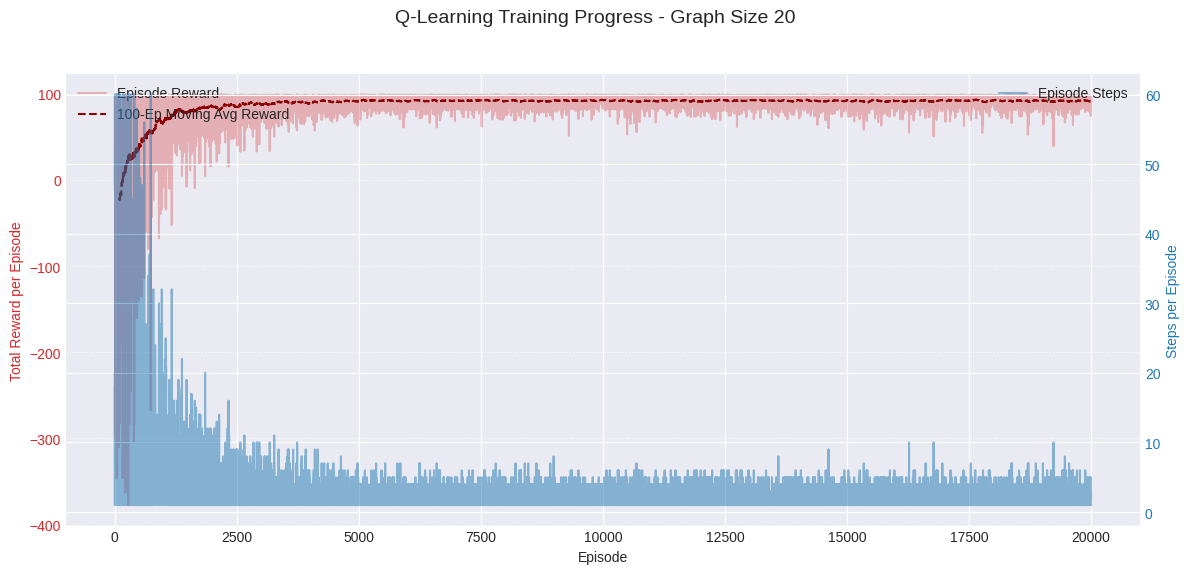


Running benchmark...

--- Running Benchmark (Size: 20, Pairs: 50) ---

===== Test Pair 1/50: 6 -> 15 (Size: 20) =====

--- D* Lite Navigation: 6 -> 15 (Size: 20) ---
D* Lite: Reached goal.
  Path: [6, 3, 15], Cost: 11.05, Steps: 2, Time: 0.0019s

--- QL Policy Execution: 6 -> 15 (Size: 20) ---
QL Policy: Reached goal.
  Path: [6, 3, 15], Cost: 11.05, Steps: 2, Time: 0.0004s
--------------------
D* Success: True, Cost: 11.05, Time: 0.0019
QL Success: True, Cost: 11.05, Time: 0.0004
Cost Ratio (QL/D*): 1.000
Step Ratio (QL/D*): 1.000
Time Ratio (QL Decision / D* Total): 0.194

===== Test Pair 2/50: 1 -> 16 (Size: 20) =====

--- D* Lite Navigation: 1 -> 16 (Size: 20) ---
D* Lite: Reached goal.
  Path: [1, 17, 16], Cost: 6.02, Steps: 2, Time: 0.0020s

--- QL Policy Execution: 1 -> 16 (Size: 20) ---
QL Policy: Reached goal.
  Path: [1, 17, 16], Cost: 6.02, Steps: 2, Time: 0.0003s
--------------------
D* Success: True, Cost: 6.02, Time: 0.0020
QL Success: True, Cost: 6.02, Time: 0.0003
Cost

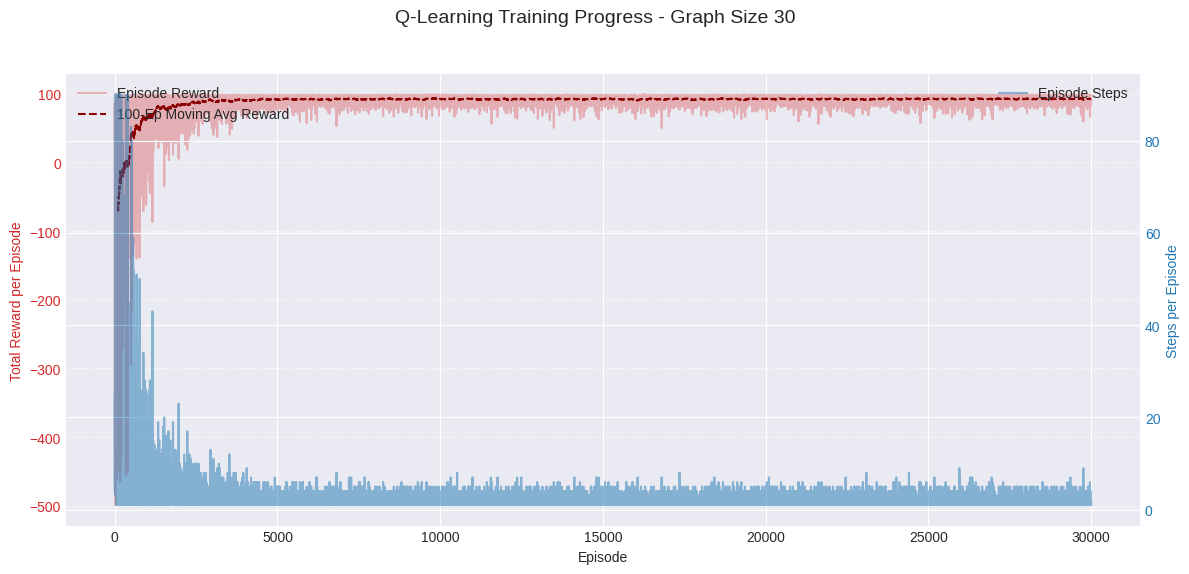


Running benchmark...

--- Running Benchmark (Size: 30, Pairs: 50) ---

===== Test Pair 1/50: 6 -> 18 (Size: 30) =====

--- D* Lite Navigation: 6 -> 18 (Size: 30) ---
D* Lite: Reached goal.
  Path: [6, 12, 18], Cost: 4.21, Steps: 2, Time: 0.0104s

--- QL Policy Execution: 6 -> 18 (Size: 30) ---
QL Policy: Reached goal.
  Path: [6, 12, 18], Cost: 4.21, Steps: 2, Time: 0.0011s
--------------------
D* Success: True, Cost: 4.21, Time: 0.0104
QL Success: True, Cost: 4.21, Time: 0.0011
Cost Ratio (QL/D*): 1.000
Step Ratio (QL/D*): 1.000
Time Ratio (QL Decision / D* Total): 0.110

===== Test Pair 2/50: 20 -> 11 (Size: 30) =====

--- D* Lite Navigation: 20 -> 11 (Size: 30) ---
D* Lite: Reached goal.
  Path: [20, 4, 11], Cost: 8.98, Steps: 2, Time: 0.0116s

--- QL Policy Execution: 20 -> 11 (Size: 30) ---
QL Policy: Reached goal.
  Path: [20, 11], Cost: 8.92, Steps: 1, Time: 0.0006s
--------------------
D* Success: True, Cost: 8.98, Time: 0.0116
QL Success: True, Cost: 8.92, Time: 0.0006
Cost R

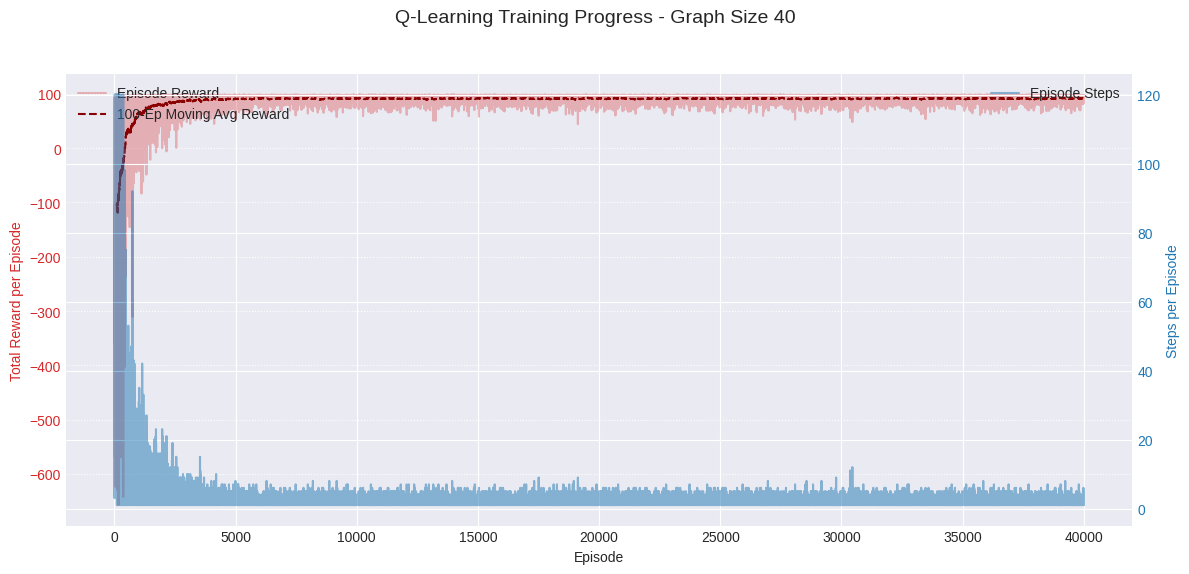


Running benchmark...

--- Running Benchmark (Size: 40, Pairs: 50) ---

===== Test Pair 1/50: 29 -> 20 (Size: 40) =====

--- D* Lite Navigation: 29 -> 20 (Size: 40) ---
D* Lite: Reached goal.
  Path: [29, 22, 20], Cost: 10.37, Steps: 2, Time: 0.0102s

--- QL Policy Execution: 29 -> 20 (Size: 40) ---
QL Policy: Reached goal.
  Path: [29, 32, 14, 20], Cost: 14.73, Steps: 3, Time: 0.0018s
--------------------
D* Success: True, Cost: 10.37, Time: 0.0102
QL Success: True, Cost: 14.73, Time: 0.0018
Cost Ratio (QL/D*): 1.421
Step Ratio (QL/D*): 1.500
Time Ratio (QL Decision / D* Total): 0.174

===== Test Pair 2/50: 21 -> 28 (Size: 40) =====

--- D* Lite Navigation: 21 -> 28 (Size: 40) ---
D* Lite: Reached goal.
  Path: [21, 4, 28], Cost: 3.06, Steps: 2, Time: 0.0069s

--- QL Policy Execution: 21 -> 28 (Size: 40) ---
QL Policy: Reached goal.
  Path: [21, 4, 28], Cost: 3.06, Steps: 2, Time: 0.0020s
--------------------
D* Success: True, Cost: 3.06, Time: 0.0069
QL Success: True, Cost: 3.06, Tim

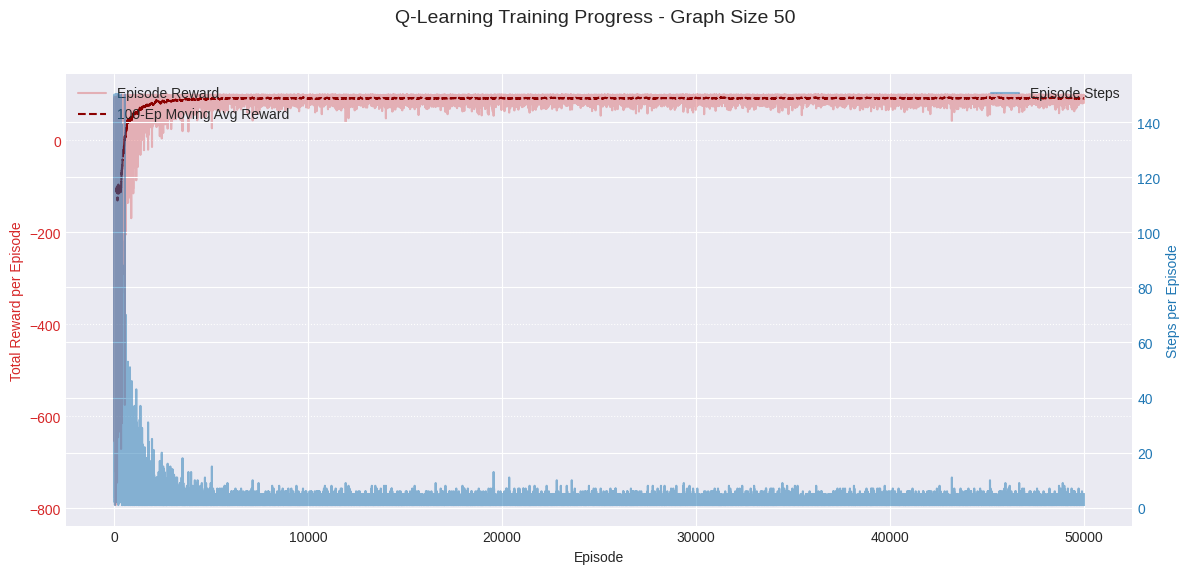


Running benchmark...

--- Running Benchmark (Size: 50, Pairs: 50) ---

===== Test Pair 1/50: 46 -> 24 (Size: 50) =====

--- D* Lite Navigation: 46 -> 24 (Size: 50) ---
D* Lite: Reached goal.
  Path: [46, 14, 24], Cost: 5.15, Steps: 2, Time: 0.0404s

--- QL Policy Execution: 46 -> 24 (Size: 50) ---
QL Policy: Reached goal.
  Path: [46, 32, 3, 24], Cost: 8.91, Steps: 3, Time: 0.0044s
--------------------
D* Success: True, Cost: 5.15, Time: 0.0404
QL Success: True, Cost: 8.91, Time: 0.0044
Cost Ratio (QL/D*): 1.730
Step Ratio (QL/D*): 1.500
Time Ratio (QL Decision / D* Total): 0.109

===== Test Pair 2/50: 24 -> 27 (Size: 50) =====

--- D* Lite Navigation: 24 -> 27 (Size: 50) ---
D* Lite: Reached goal.
  Path: [24, 17, 28, 27], Cost: 5.31, Steps: 3, Time: 0.0366s

--- QL Policy Execution: 24 -> 27 (Size: 50) ---
QL Policy: Reached goal.
  Path: [24, 14, 27], Cost: 5.83, Steps: 2, Time: 0.0029s
--------------------
D* Success: True, Cost: 5.31, Time: 0.0366
QL Success: True, Cost: 5.83, Ti

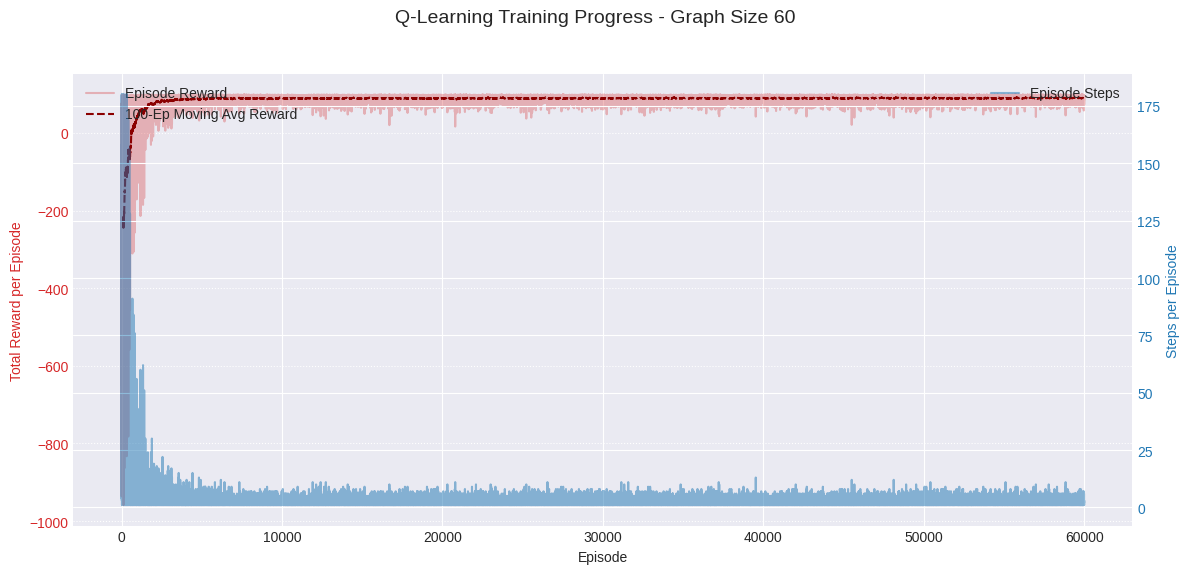


Running benchmark...

--- Running Benchmark (Size: 60, Pairs: 50) ---

===== Test Pair 1/50: 34 -> 7 (Size: 60) =====

--- D* Lite Navigation: 34 -> 7 (Size: 60) ---
D* Lite: Reached goal.
  Path: [34, 7], Cost: 1.73, Steps: 1, Time: 0.0085s

--- QL Policy Execution: 34 -> 7 (Size: 60) ---
QL Policy: Reached goal.
  Path: [34, 56, 7], Cost: 7.30, Steps: 2, Time: 0.0043s
--------------------
D* Success: True, Cost: 1.73, Time: 0.0085
QL Success: True, Cost: 7.30, Time: 0.0043
Cost Ratio (QL/D*): 4.232
Step Ratio (QL/D*): 2.000
Time Ratio (QL Decision / D* Total): 0.505

===== Test Pair 2/50: 58 -> 59 (Size: 60) =====

--- D* Lite Navigation: 58 -> 59 (Size: 60) ---
D* Lite: Reached goal.
  Path: [58, 13, 43, 59], Cost: 6.08, Steps: 3, Time: 0.0748s

--- QL Policy Execution: 58 -> 59 (Size: 60) ---
QL Policy: Reached goal.
  Path: [58, 52, 22, 59], Cost: 7.75, Steps: 3, Time: 0.0063s
--------------------
D* Success: True, Cost: 6.08, Time: 0.0748
QL Success: True, Cost: 7.75, Time: 0.00

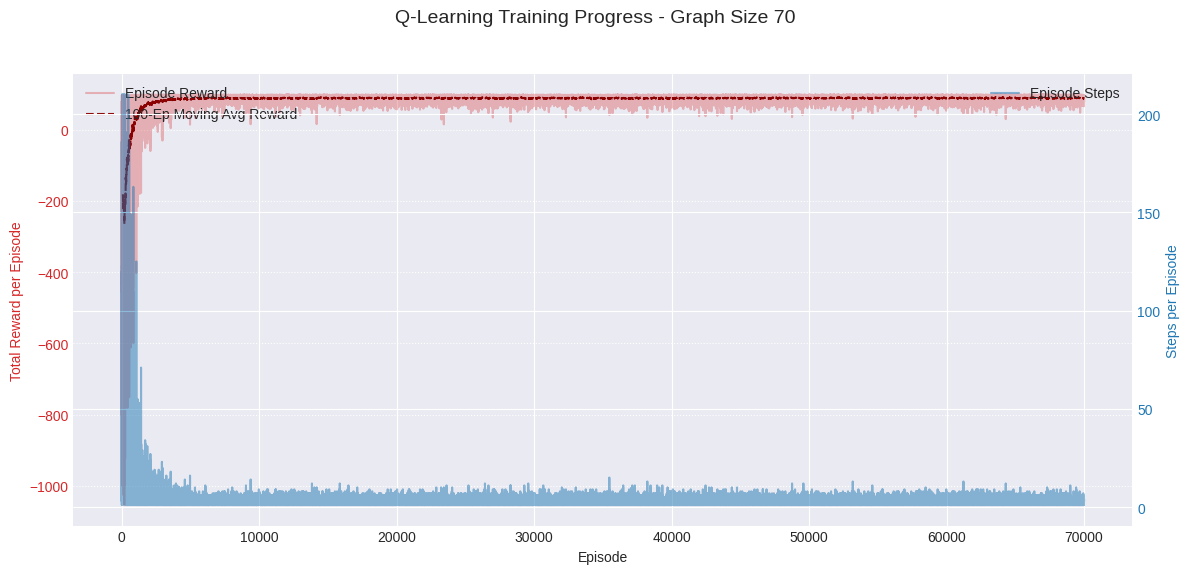


Running benchmark...

--- Running Benchmark (Size: 70, Pairs: 50) ---

===== Test Pair 1/50: 29 -> 14 (Size: 70) =====

--- D* Lite Navigation: 29 -> 14 (Size: 70) ---
D* Lite: Reached goal.
  Path: [29, 26, 14], Cost: 5.02, Steps: 2, Time: 0.0289s

--- QL Policy Execution: 29 -> 14 (Size: 70) ---
QL Policy: Reached goal.
  Path: [29, 26, 14], Cost: 5.02, Steps: 2, Time: 0.0057s
--------------------
D* Success: True, Cost: 5.02, Time: 0.0289
QL Success: True, Cost: 5.02, Time: 0.0057
Cost Ratio (QL/D*): 1.000
Step Ratio (QL/D*): 1.000
Time Ratio (QL Decision / D* Total): 0.198

===== Test Pair 2/50: 48 -> 15 (Size: 70) =====

--- D* Lite Navigation: 48 -> 15 (Size: 70) ---
D* Lite: Reached goal.
  Path: [48, 15], Cost: 7.73, Steps: 1, Time: 0.0076s

--- QL Policy Execution: 48 -> 15 (Size: 70) ---
QL Policy: Reached goal.
  Path: [48, 29, 12, 15], Cost: 13.19, Steps: 3, Time: 0.0048s
--------------------
D* Success: True, Cost: 7.73, Time: 0.0076
QL Success: True, Cost: 13.19, Time: 0

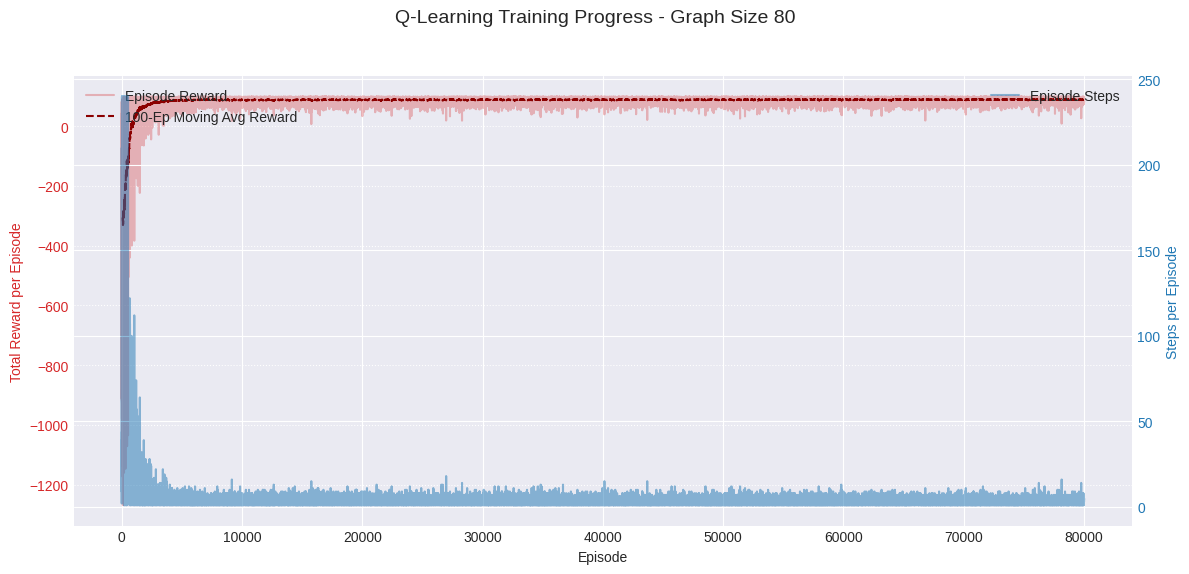


Running benchmark...

--- Running Benchmark (Size: 80, Pairs: 50) ---

===== Test Pair 1/50: 19 -> 43 (Size: 80) =====

--- D* Lite Navigation: 19 -> 43 (Size: 80) ---
D* Lite: Reached goal.
  Path: [19, 21, 3, 43], Cost: 4.26, Steps: 3, Time: 0.1042s

--- QL Policy Execution: 19 -> 43 (Size: 80) ---
QL Policy: Reached goal.
  Path: [19, 16, 9, 43], Cost: 8.44, Steps: 3, Time: 0.0070s
--------------------
D* Success: True, Cost: 4.26, Time: 0.1042
QL Success: True, Cost: 8.44, Time: 0.0070
Cost Ratio (QL/D*): 1.979
Step Ratio (QL/D*): 1.000
Time Ratio (QL Decision / D* Total): 0.067

===== Test Pair 2/50: 64 -> 69 (Size: 80) =====

--- D* Lite Navigation: 64 -> 69 (Size: 80) ---
D* Lite: Reached goal.
  Path: [64, 79, 69], Cost: 4.82, Steps: 2, Time: 0.0603s

--- QL Policy Execution: 64 -> 69 (Size: 80) ---
QL Policy: Reached goal.
  Path: [64, 51, 36, 74, 69], Cost: 8.42, Steps: 4, Time: 0.0092s
--------------------
D* Success: True, Cost: 4.82, Time: 0.0603
QL Success: True, Cost: 8

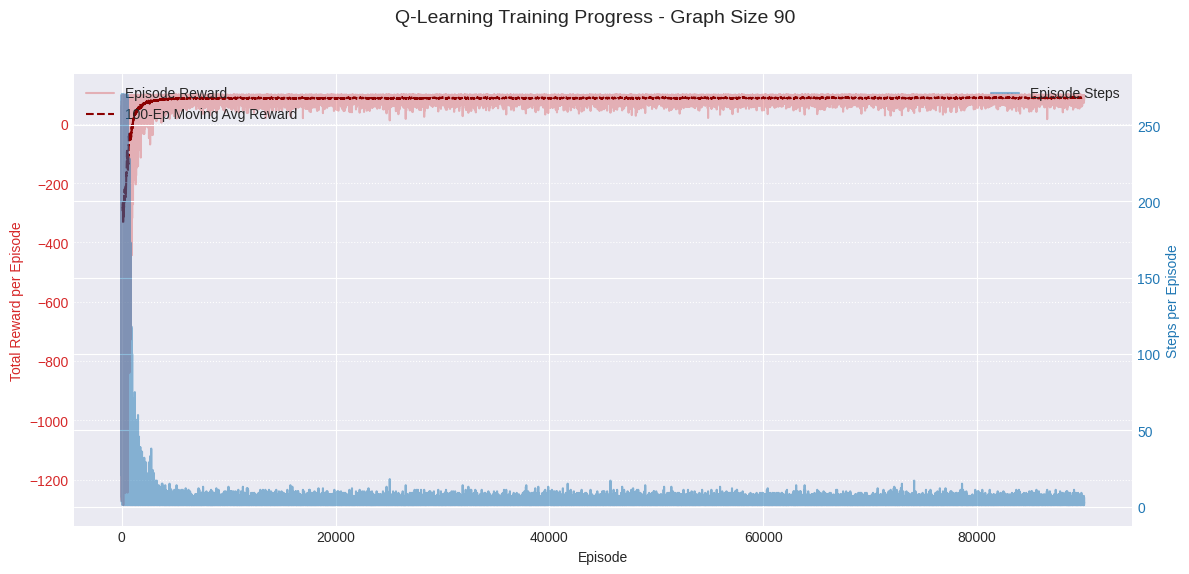


Running benchmark...

--- Running Benchmark (Size: 90, Pairs: 50) ---

===== Test Pair 1/50: 13 -> 36 (Size: 90) =====

--- D* Lite Navigation: 13 -> 36 (Size: 90) ---
D* Lite: Reached goal.
  Path: [13, 36], Cost: 3.13, Steps: 1, Time: 0.0373s

--- QL Policy Execution: 13 -> 36 (Size: 90) ---
QL Policy: Reached goal.
  Path: [13, 56, 11, 36], Cost: 7.10, Steps: 3, Time: 0.0083s
--------------------
D* Success: True, Cost: 3.13, Time: 0.0373
QL Success: True, Cost: 7.10, Time: 0.0083
Cost Ratio (QL/D*): 2.265
Step Ratio (QL/D*): 3.000
Time Ratio (QL Decision / D* Total): 0.222

===== Test Pair 2/50: 10 -> 43 (Size: 90) =====

--- D* Lite Navigation: 10 -> 43 (Size: 90) ---
D* Lite: Reached goal.
  Path: [10, 43], Cost: 9.38, Steps: 1, Time: 0.0577s

--- QL Policy Execution: 10 -> 43 (Size: 90) ---
QL Policy: Reached goal.
  Path: [10, 29, 43], Cost: 10.21, Steps: 2, Time: 0.0056s
--------------------
D* Success: True, Cost: 9.38, Time: 0.0577
QL Success: True, Cost: 10.21, Time: 0.005

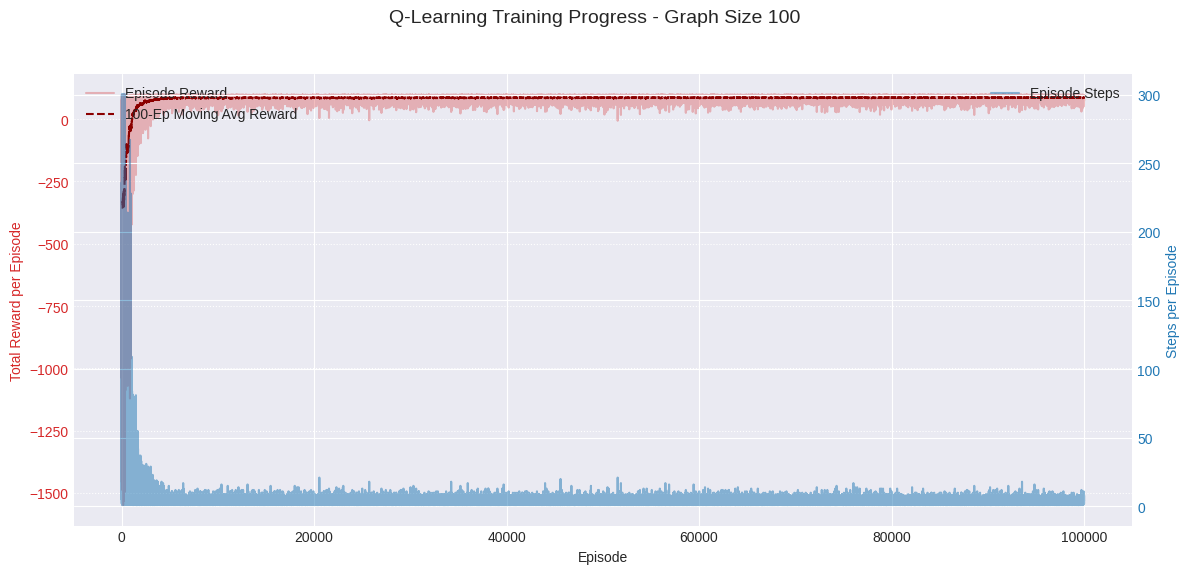


Running benchmark...

--- Running Benchmark (Size: 100, Pairs: 50) ---

===== Test Pair 1/50: 1 -> 28 (Size: 100) =====

--- D* Lite Navigation: 1 -> 28 (Size: 100) ---
D* Lite: Reached goal.
  Path: [1, 9, 28], Cost: 4.19, Steps: 2, Time: 0.1221s

--- QL Policy Execution: 1 -> 28 (Size: 100) ---
QL Policy: Reached goal.
  Path: [1, 30, 73, 4, 38, 56, 28], Cost: 26.22, Steps: 6, Time: 0.0209s
--------------------
D* Success: True, Cost: 4.19, Time: 0.1221
QL Success: True, Cost: 26.22, Time: 0.0209
Cost Ratio (QL/D*): 6.249
Step Ratio (QL/D*): 3.000
Time Ratio (QL Decision / D* Total): 0.171

===== Test Pair 2/50: 4 -> 55 (Size: 100) =====

--- D* Lite Navigation: 4 -> 55 (Size: 100) ---
D* Lite: Reached goal.
  Path: [4, 2, 55], Cost: 9.44, Steps: 2, Time: 0.0680s

--- QL Policy Execution: 4 -> 55 (Size: 100) ---
QL Policy: Reached goal.
  Path: [4, 62, 52, 55], Cost: 15.22, Steps: 3, Time: 0.0196s
--------------------
D* Success: True, Cost: 9.44, Time: 0.0680
QL Success: True, Cost

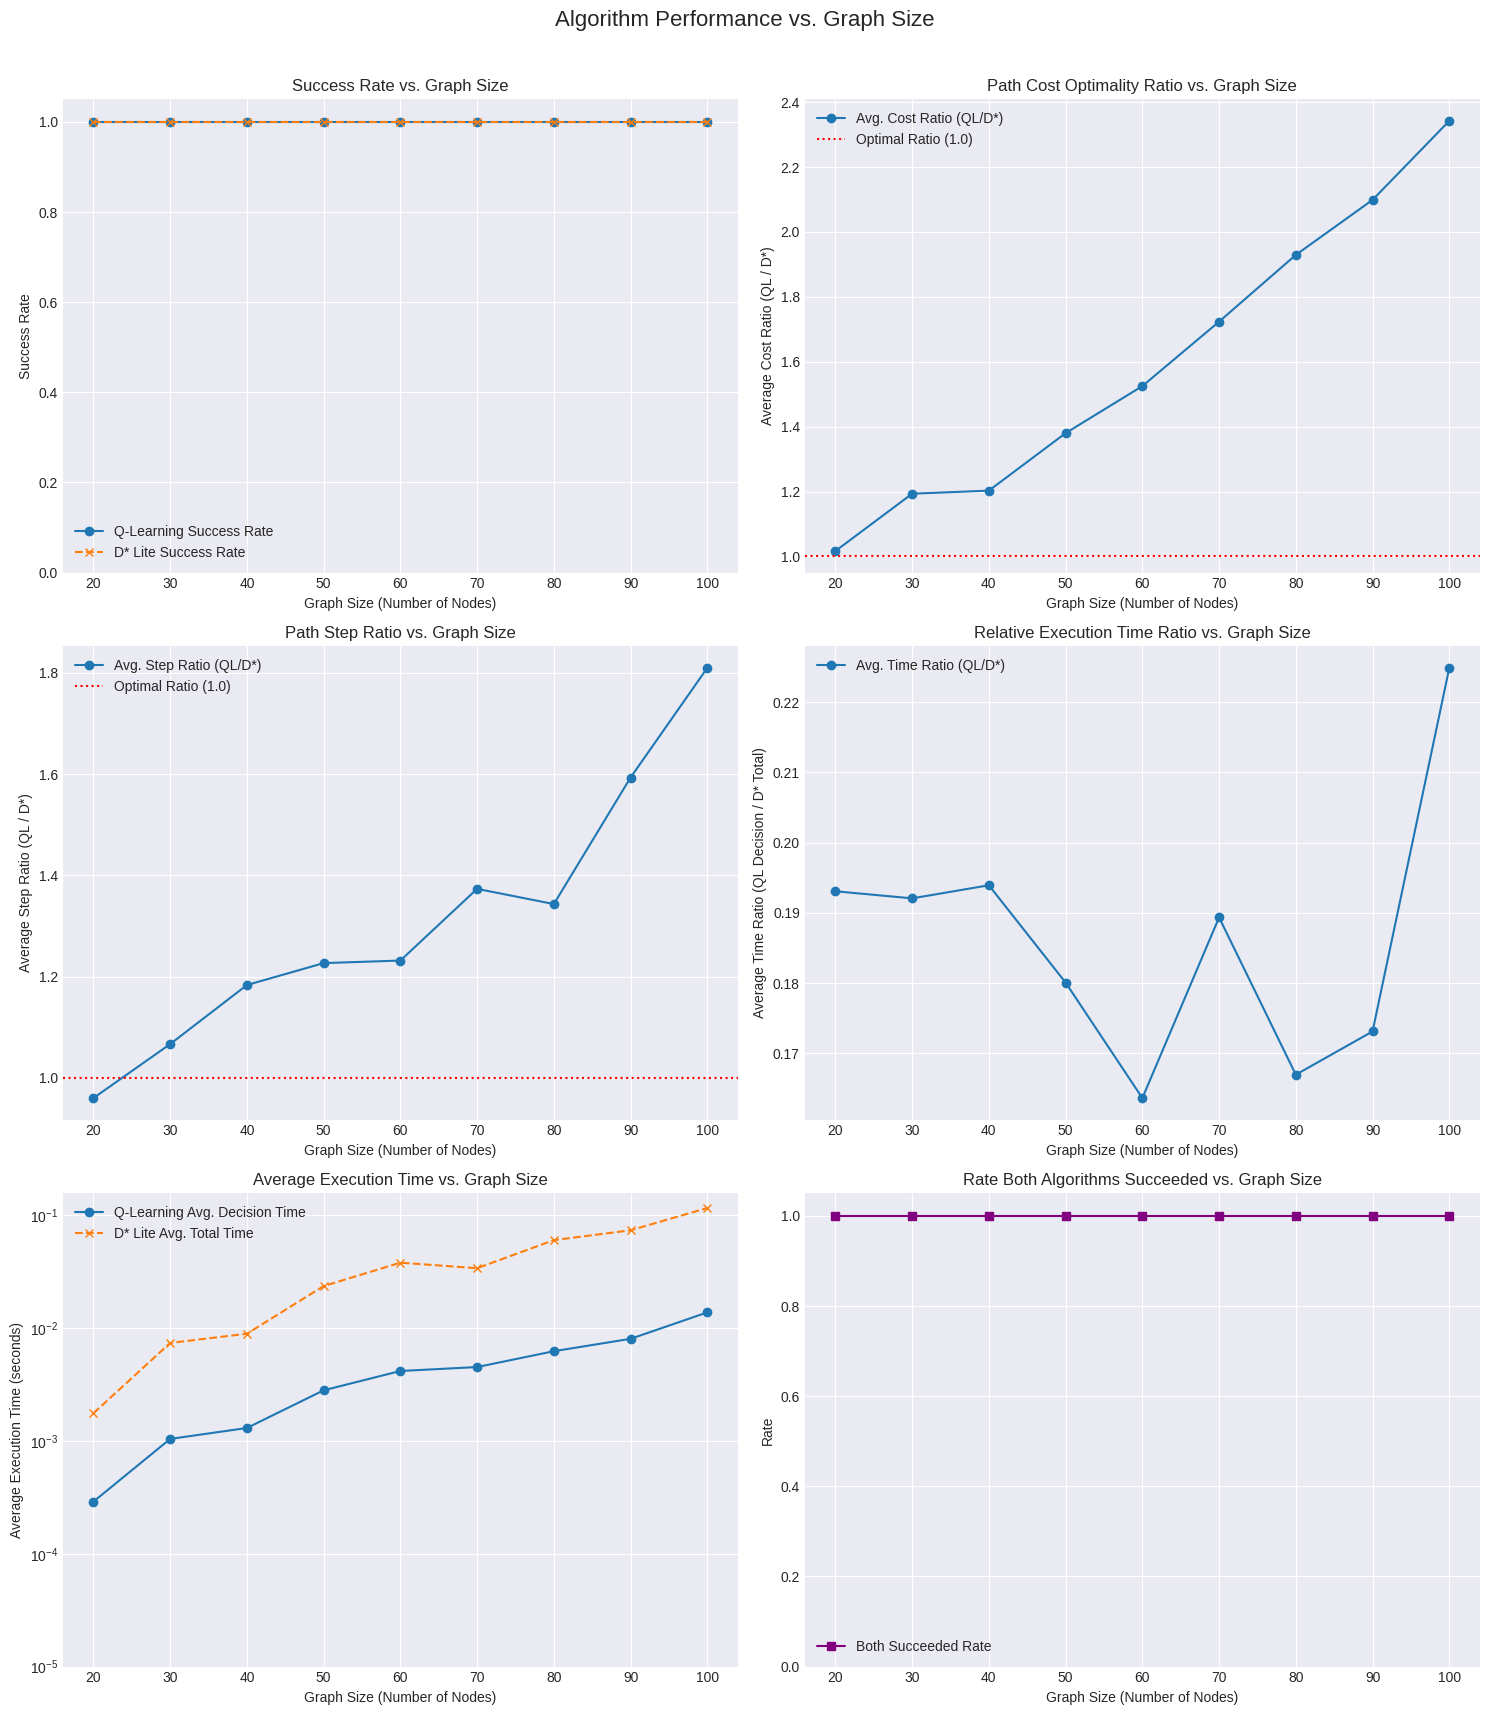

Streaming output truncated to the last 5000 lines.

===== Test Pair 1/50: 6 -> 27 (Size: 30) =====

--- D* Lite Navigation: 6 -> 27 (Size: 30) ---
D* Lite: Reached goal.
  Path: [6, 12, 27], Cost: 3.20, Steps: 2, Time: 0.0084s

--- QL Policy Execution: 6 -> 27 (Size: 30) ---
QL Policy: Reached goal.
  Path: [6, 12, 27], Cost: 3.20, Steps: 2, Time: 0.0007s
--------------------
D* Success: True, Cost: 3.20, Time: 0.0084
QL Success: True, Cost: 3.20, Time: 0.0007
Cost Ratio (QL/D*): 1.000
Step Ratio (QL/D*): 1.000
Time Ratio (QL Decision / D* Total): 0.078

===== Test Pair 2/50: 19 -> 0 (Size: 30) =====

--- D* Lite Navigation: 19 -> 0 (Size: 30) ---
D* Lite: Reached goal.
  Path: [19, 18, 16, 0], Cost: 13.47, Steps: 3, Time: 0.0125s

--- QL Policy Execution: 19 -> 0 (Size: 30) ---
QL Policy: Reached goal.
  Path: [19, 18, 16, 0], Cost: 13.47, Steps: 3, Time: 0.0010s
--------------------
D* Success: True, Cost: 13.47, Time: 0.0125
QL Success: True, Cost: 13.47, Time: 0.0010
Cost Ratio (QL

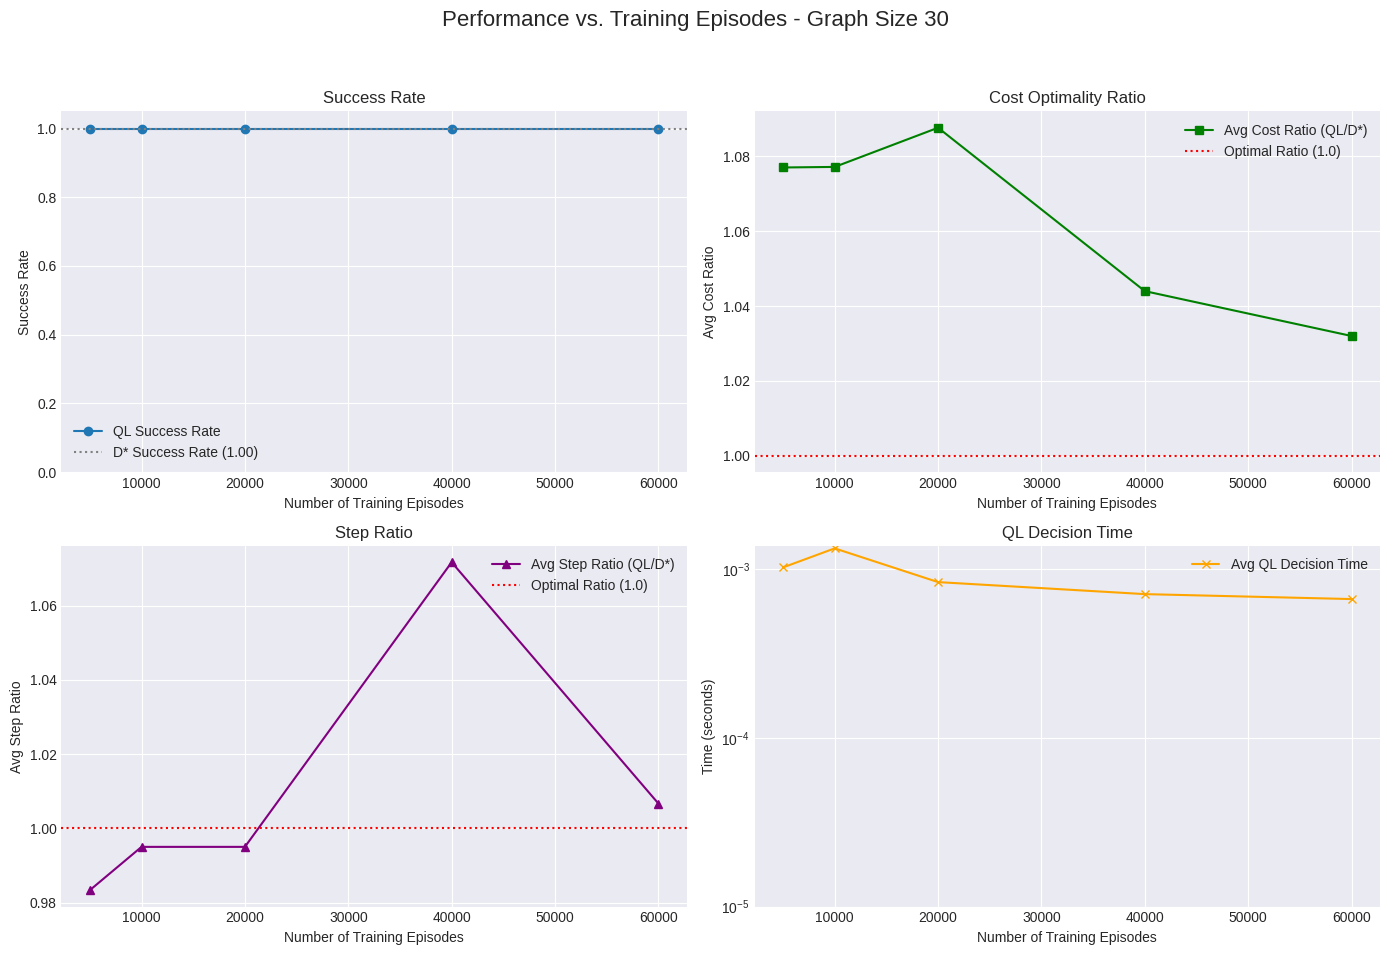

Performance vs Episodes plot saved for size 60.


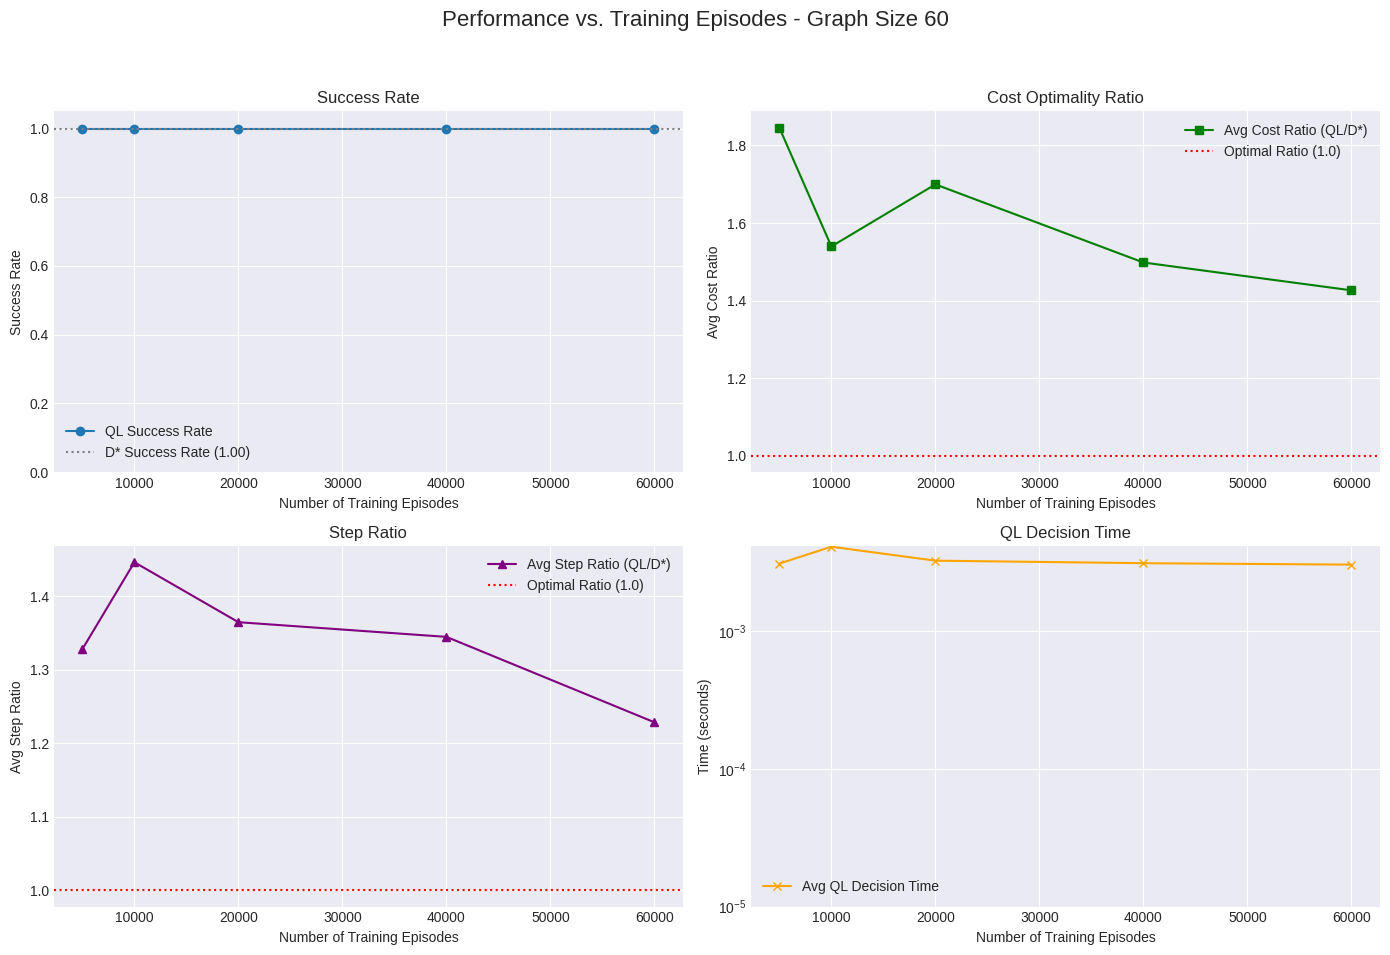


--- Generating NEW Visualization: Metric Distributions ---


--- Plotting Metric Distributions ---


OSError: 'seaborn-v0_8-v0_8-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [7]:
# ======================================================================
# --- NEW SECTION: Adaptive Episodes & Enhanced Benchmarking Loop ---
# ======================================================================
import pandas as pd # Using pandas for easier data handling in new plots
import seaborn as sns # Seaborn for potentially better boxplots

print("\n" + "="*50)
print("--- Running NEW Experiment: Adaptive Episodes & Training Curve Plotting ---")
print("="*50 + "\n")

# --- Configuration (Adjust as needed) ---
# Using the same NODE_SIZES etc. as the original main block for consistency
# NODE_SIZES = list(range(20, 101, 10)) # Or keep from previous run
# BASE_SEED = 42
# CONNECTIVITY = 0.25
# BUSY_NODE_INTERVAL = 5

# Q-Learning Training Parameters (Adaptive)
BASE_NUM_EPISODES = 20000  # Episodes for the SMALLEST graph size
# MAX_STEPS_FACTOR = 3
# BATCH_SIZE = 64
# NUM_TEST_PAIRS_PER_SIZE = 50
# MAX_BENCHMARK_STEPS_FACTOR = 3
# LEARNING_RATE = 0.1 # Keep consistent QL params
# DISCOUNT_FACTOR = 0.95
# EXPLORATION_DECAY = 0.9995
# MIN_EXPLORATION_RATE = 0.05


# --- Helper Function: Plot Training Curve ---
def plot_training_curve(stats, size, filename=None):
    """Plots episode rewards and steps from Q-learning training stats."""
    if not stats or 'episode_rewards' not in stats or not stats['episode_rewards']:
        print(f"No training stats to plot for size {size}.")
        return

    rewards = stats['episode_rewards']
    steps = stats['episode_steps']
    episodes = range(1, len(rewards) + 1)

    # Calculate moving average for rewards (e.g., window of 100 episodes)
    window_size = 100
    if len(rewards) >= window_size:
        rewards_ma = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        episodes_ma = range(window_size, len(rewards) + 1)
    else:
        rewards_ma = []
        episodes_ma = []

    fig, ax1 = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'Q-Learning Training Progress - Graph Size {size}', fontsize=14)

    color = 'tab:red'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward per Episode', color=color)
    ax1.plot(episodes, rewards, color=color, alpha=0.3, label='Episode Reward')
    if list(rewards_ma): # Check if moving average was calculated
      ax1.plot(episodes_ma, rewards_ma, color='darkred', linestyle='--', label=f'{window_size}-Ep Moving Avg Reward')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.grid(True, axis='y', linestyle=':')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Steps per Episode', color=color)
    ax2.plot(episodes, steps, color=color, alpha=0.5, label='Episode Steps')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    if filename:
        plt.savefig(filename)
        print(f"Training curve saved to {filename}")
    plt.show()


# --- Regenerate Graphs (or ensure 'graphs' dictionary exists from previous run) ---
# Assuming 'graphs' dictionary populated from the first part of the script
if 'graphs' not in locals() or not graphs:
     print("ERROR: 'graphs' dictionary not found or empty. Run graph generation first.")
     # You might need to copy the graph generation loop here if running standalone
     # exit() # Or handle appropriately


# --- Adaptive Benchmarking Loop ---
all_benchmark_summaries_adaptive = []
print("\n--- Starting Adaptive Episode Benchmarking Across Sizes ---")

if not NODE_SIZES:
     print("Error: NODE_SIZES list is empty.")
else:
    min_node_size = min(NODE_SIZES) if NODE_SIZES else 20 # Base size for scaling

    for n_nodes in NODE_SIZES:
        print(f"\n{'='*15} Processing Graph Size: {n_nodes} {'='*15}")
        graph_template = graphs.get(n_nodes)

        if graph_template is None or graph_template.number_of_nodes() < 2:
            print(f"Skipping size {n_nodes} due to graph issue.")
            all_benchmark_summaries_adaptive.append(None) # Keep list length consistent
            continue

        # --- Calculate Adaptive Episodes ---
        scaling_factor = n_nodes / min_node_size
        current_num_episodes = int(BASE_NUM_EPISODES * scaling_factor)
        current_max_steps = n_nodes * MAX_STEPS_FACTOR
        print(f"Targeting {current_num_episodes} training episodes for size {n_nodes}.")

        # --- Instantiate and Train Q-Learning Agent ---
        print(f"Initializing Q-Learning agent...")
        try:
            ql_agent_adaptive = QLearningPathFinder(
                graph=graph_template,
                learning_rate=0.1, # Use consistent params from original run
                discount_factor=0.95,
                exploration_rate=1.0,
                exploration_decay=0.9995,
                min_exploration_rate=0.05
            )
        except Exception as e:
            print(f"ERROR initializing QL Agent: {e}")
            all_benchmark_summaries_adaptive.append(None)
            continue

        print(f"Training QL for {current_num_episodes} episodes...")
        try:
             training_stats = ql_agent_adaptive.train(
                num_episodes=current_num_episodes,
                max_steps_per_episode=current_max_steps,
                experience_replay_batch_size=BATCH_SIZE
             )
             # --- Plot Training Curve ---
             plot_training_curve(training_stats, n_nodes, filename=f"training_curve_size_{n_nodes}.png")

             if not training_stats or not training_stats.get('episode_rewards'):
                  print(f"Warning: QL training might have failed or produced no stats.")
        except Exception as e:
             print(f"ERROR during QL training for size {n_nodes}: {e}")
             print("Skipping benchmarking for this size.")
             all_benchmark_summaries_adaptive.append(None)
             continue # Skip to next size if training fails

        # --- Run Benchmark for this size ---
        print(f"\nRunning benchmark...")
        try:
             # Use the standard benchmark function
             benchmark_results = benchmark_algorithms(
                graph_template=graph_template,
                ql_agent=ql_agent_adaptive, # Use the newly trained agent
                num_test_pairs=NUM_TEST_PAIRS_PER_SIZE,
                max_steps_per_run=(n_nodes * MAX_BENCHMARK_STEPS_FACTOR)
             )
             if benchmark_results and 'summary' in benchmark_results and benchmark_results['summary']:
                 benchmark_results['summary']['node_size'] = n_nodes # Ensure size is in summary
                 benchmark_results['summary']['trained_episodes'] = current_num_episodes # Store how many episodes it was trained for
                 all_benchmark_summaries_adaptive.append(benchmark_results)
             else:
                 print(f"Warning: Benchmark for size {n_nodes} did not return valid results.")
                 all_benchmark_summaries_adaptive.append(None)
        except Exception as e:
             print(f"ERROR during benchmarking for size {n_nodes}: {e}")
             all_benchmark_summaries_adaptive.append(None)

print("\n--- Adaptive Episode Benchmarking Across Sizes Complete ---")

# --- Plotting Results (Using original plot function with the new summary list) ---
print("\n--- Generating Performance Plots (Adaptive Episodes) ---")
# Filter out None entries before plotting
valid_summaries_adaptive = [s for s in all_benchmark_summaries_adaptive if s is not None]
if valid_summaries_adaptive:
    plot_benchmark_results(valid_summaries_adaptive)
else:
    print("No valid benchmark summaries collected for adaptive episode runs.")


# ============================================================================
# --- NEW SECTION: Ratio Matrix (Performance vs. Training Episodes) ---
# ============================================================================

print("\n" + "="*50)
print("--- Running NEW Experiment: Performance vs. Training Episodes ---")
print("="*50 + "\n")

# --- Configuration ---
SIZES_TO_TEST_RATIO = [30, 60] # Choose one small and one medium/large size
EPISODE_COUNTS_TO_TEST = [5000, 10000, 20000, 40000, 60000] # Varying training durations
# Use other parameters (LR, gamma, benchmark pairs etc.) consistently

ratio_results = defaultdict(list) # Store results: size -> list of (episodes, summary)

for n_nodes_ratio in SIZES_TO_TEST_RATIO:
    print(f"\n--- Testing Effect of Episodes for Size: {n_nodes_ratio} ---")
    graph_template_ratio = graphs.get(n_nodes_ratio)

    if graph_template_ratio is None or graph_template_ratio.number_of_nodes() < 2:
        print(f"Skipping size {n_nodes_ratio} due to graph issue.")
        continue

    for num_eps in EPISODE_COUNTS_TO_TEST:
        print(f"\n--- Training with {num_eps} episodes ---")
        max_steps_ratio = n_nodes_ratio * MAX_STEPS_FACTOR

        # --- Instantiate FRESH Q-Learning Agent ---
        # Important: Create a new agent for each episode count to avoid sequential effects
        print(f"Initializing FRESH Q-Learning agent...")
        try:
            ql_agent_ratio = QLearningPathFinder(
                graph=graph_template_ratio,
                learning_rate=0.1, # Use consistent params
                discount_factor=0.95,
                exploration_rate=1.0,
                exploration_decay=0.9995,
                min_exploration_rate=0.05
            )
        except Exception as e:
            print(f"ERROR initializing QL Agent for ratio test (size {n_nodes_ratio}, eps {num_eps}): {e}")
            continue # Skip this episode count

        # --- Train Agent ---
        print(f"Training QL for {num_eps} episodes...")
        try:
            # We can optionally plot training curves here too, but might be too many plots
             ql_agent_ratio.train(
                num_episodes=num_eps,
                max_steps_per_episode=max_steps_ratio,
                experience_replay_batch_size=BATCH_SIZE
             )
        except Exception as e:
             print(f"ERROR during QL training for ratio test (size {n_nodes_ratio}, eps {num_eps}): {e}")
             print("Skipping benchmarking for this configuration.")
             continue

        # --- Run Benchmark ---
        print(f"\nRunning benchmark (trained for {num_eps} eps)...")
        try:
             # Benchmark this specific agent
             benchmark_res = benchmark_algorithms(
                graph_template=graph_template_ratio,
                ql_agent=ql_agent_ratio,
                num_test_pairs=NUM_TEST_PAIRS_PER_SIZE, # Use same number of test pairs
                max_steps_per_run=(n_nodes_ratio * MAX_BENCHMARK_STEPS_FACTOR)
             )
             if benchmark_res and 'summary' in benchmark_res and benchmark_res['summary']:
                 # Store the summary along with the episode count
                 ratio_results[n_nodes_ratio].append((num_eps, benchmark_res['summary']))
             else:
                 print(f"Warning: Benchmark failed for size {n_nodes_ratio}, {num_eps} episodes.")
                 ratio_results[n_nodes_ratio].append((num_eps, None)) # Record failure
        except Exception as e:
             print(f"ERROR during benchmarking for ratio test (size {n_nodes_ratio}, eps {num_eps}): {e}")
             ratio_results[n_nodes_ratio].append((num_eps, None))

# --- Plot Ratio Matrix Results ---
print("\n--- Generating Performance vs. Episodes Plots ---")

for size, results_list in ratio_results.items():
    if not results_list: continue

    episodes = [r[0] for r in results_list]
    summaries = [r[1] for r in results_list]

    # Extract metrics, handling None summaries
    ql_success = [s.get('ql_success_rate', np.nan) if s else np.nan for s in summaries]
    dstar_success = [s.get('dstar_success_rate', np.nan) if s else np.nan for s in summaries] # Should be constant for D*
    avg_cost_ratio = [s.get('avg_cost_ratio', np.nan) if s else np.nan for s in summaries]
    avg_step_ratio = [s.get('avg_step_ratio', np.nan) if s else np.nan for s in summaries]
    avg_ql_time = [s.get('avg_ql_decision_time', np.nan) if s else np.nan for s in summaries]
    both_success = [s.get('both_success_rate', np.nan) if s else np.nan for s in summaries]


    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axs = plt.subplots(2, 2, figsize=(14, 10)) # Grid for metrics
    fig.suptitle(f'Performance vs. Training Episodes - Graph Size {size}', fontsize=16)

    # Plot 1: Success Rates
    ax = axs[0, 0]
    ax.plot(episodes, ql_success, marker='o', linestyle='-', label='QL Success Rate')
    # D* success rate should be constant, plot as horizontal line if data exists
    valid_dstar_success = [ds for ds in dstar_success if not np.isnan(ds)]
    if valid_dstar_success:
         ax.axhline(valid_dstar_success[0], color='gray', linestyle=':', label=f'D* Success Rate ({valid_dstar_success[0]:.2f})')
    ax.set_xlabel('Number of Training Episodes')
    ax.set_ylabel('Success Rate')
    ax.set_title('Success Rate')
    ax.legend()
    ax.set_ylim(0, 1.05)
    ax.grid(True)

    # Plot 2: Avg Cost Ratio (QL/D*)
    ax = axs[0, 1]
    ax.plot(episodes, avg_cost_ratio, marker='s', linestyle='-', color='green', label='Avg Cost Ratio (QL/D*)')
    ax.axhline(1, color='r', linestyle=':', label='Optimal Ratio (1.0)')
    ax.set_xlabel('Number of Training Episodes')
    ax.set_ylabel('Avg Cost Ratio')
    ax.set_title('Cost Optimality Ratio')
    ax.legend()
    ax.grid(True)

    # Plot 3: Avg Step Ratio (QL/D*)
    ax = axs[1, 0]
    ax.plot(episodes, avg_step_ratio, marker='^', linestyle='-', color='purple', label='Avg Step Ratio (QL/D*)')
    ax.axhline(1, color='r', linestyle=':', label='Optimal Ratio (1.0)')
    ax.set_xlabel('Number of Training Episodes')
    ax.set_ylabel('Avg Step Ratio')
    ax.set_title('Step Ratio')
    ax.legend()
    ax.grid(True)

    # Plot 4: Avg QL Decision Time
    ax = axs[1, 1]
    ax.plot(episodes, avg_ql_time, marker='x', linestyle='-', color='orange', label='Avg QL Decision Time')
    ax.set_xlabel('Number of Training Episodes')
    ax.set_ylabel('Time (seconds)')
    ax.set_title('QL Decision Time')
    ax.legend()
    ax.grid(True)
    if any(t > 0 for t in avg_ql_time if not np.isnan(t)): # Avoid log scale if all times are tiny/zero/nan
        ax.set_yscale('log')
        ax.set_ylim(bottom=1e-5)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"performance_vs_episodes_size_{size}.png")
    print(f"Performance vs Episodes plot saved for size {size}.")
    plt.show()




--- Generating NEW Visualization: Metric Distributions ---


--- Plotting Metric Distributions ---
Metric distribution plot saved.


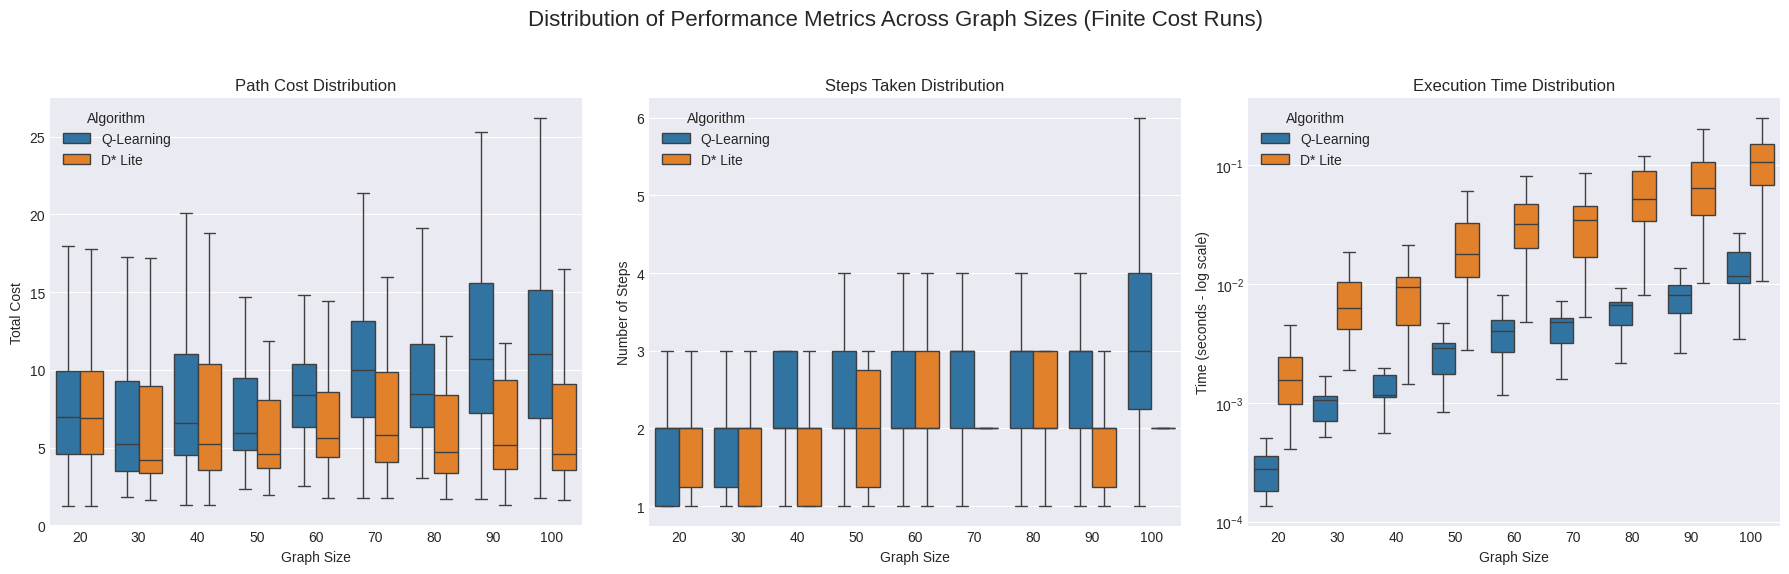


--- Additional Experiments Finished ---


In [10]:

# ======================================================================
# --- NEW SECTION: Box Plot Visualization of Distributions ---
# ======================================================================
print("\n" + "="*50)
print("--- Generating NEW Visualization: Metric Distributions ---")
print("="*50 + "\n")

def plot_metric_distributions(all_benchmark_data):
    """
    Generates box plots for costs, steps, and times for QL vs D*.
    Input should be the list of detailed results dictionaries
    (e.g., from all_benchmark_summaries_adaptive[size]['detailed_results']).
    """
    if not all_benchmark_data:
        print("No detailed benchmark data provided for distribution plots.")
        return

    # Combine detailed results from all valid summaries into a Pandas DataFrame
    all_details = []
    for benchmark_run in all_benchmark_data:
        if benchmark_run and 'detailed_results' in benchmark_run:
            # Add node size to each detailed result entry
            size = benchmark_run['summary'].get('node_size', 'Unknown')
            trained_eps = benchmark_run['summary'].get('trained_episodes', 'Unknown') # If using adaptive results
            for detail in benchmark_run['detailed_results']:
                 detail['node_size'] = size
                 detail['trained_episodes'] = trained_eps
                 all_details.append(detail)

    if not all_details:
         print("No valid detailed results found to plot distributions.")
         return

    df = pd.DataFrame(all_details)

    # Filter out infinite costs for meaningful plots
    df_finite = df[(df['ql_cost'] != float('inf')) & (df['dstar_cost'] != float('inf'))].copy()
    if df_finite.empty:
         print("No runs where both algorithms had finite cost - cannot plot distributions.")
         return

    # Create long-form data for easier plotting with seaborn
    df_cost = df_finite.melt(id_vars=['node_size'], value_vars=['ql_cost', 'dstar_cost'], var_name='Algorithm', value_name='Cost')
    df_steps = df_finite.melt(id_vars=['node_size'], value_vars=['ql_steps', 'dstar_steps'], var_name='Algorithm', value_name='Steps')
    df_time = df_finite.melt(id_vars=['node_size'], value_vars=['ql_decision_time', 'dstar_time'], var_name='Algorithm', value_name='Time')

    # Map algorithm names for clarity
    algo_map = {'ql_cost': 'Q-Learning', 'dstar_cost': 'D* Lite',
                'ql_steps': 'Q-Learning', 'dstar_steps': 'D* Lite',
                'ql_decision_time': 'Q-Learning', 'dstar_time': 'D* Lite'}
    df_cost['Algorithm'] = df_cost['Algorithm'].map(algo_map)
    df_steps['Algorithm'] = df_steps['Algorithm'].map(algo_map)
    df_time['Algorithm'] = df_time['Algorithm'].map(algo_map)


    # Create Plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Distribution of Performance Metrics Across Graph Sizes (Finite Cost Runs)', fontsize=16)

    # 1. Cost Distribution
    sns.boxplot(x='node_size', y='Cost', hue='Algorithm', data=df_cost, ax=axs[0], showfliers=False) # Hide outliers for clarity
    axs[0].set_title('Path Cost Distribution')
    axs[0].set_xlabel('Graph Size')
    axs[0].set_ylabel('Total Cost')
    axs[0].legend(title='Algorithm')

    # 2. Steps Distribution
    sns.boxplot(x='node_size', y='Steps', hue='Algorithm', data=df_steps, ax=axs[1], showfliers=False)
    axs[1].set_title('Steps Taken Distribution')
    axs[1].set_xlabel('Graph Size')
    axs[1].set_ylabel('Number of Steps')
    axs[1].legend(title='Algorithm')

    # 3. Time Distribution (Using Log Scale for time)
    sns.boxplot(x='node_size', y='Time', hue='Algorithm', data=df_time, ax=axs[2], showfliers=False)
    axs[2].set_title('Execution Time Distribution')
    axs[2].set_xlabel('Graph Size')
    axs[2].set_ylabel('Time (seconds - log scale)')
    axs[2].set_yscale('log')
    axs[2].legend(title='Algorithm')
    # Adjust ylim if necessary, e.g., axs[2].set_ylim(bottom=1e-5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("metric_distributions.png")
    print("Metric distribution plot saved.")
    plt.show()


# --- Execute the Distribution Plotting ---
# Use the results from the adaptive episode run (or the original run if preferred)
print("\n--- Plotting Metric Distributions ---")
if 'all_benchmark_summaries_adaptive' in locals() and all_benchmark_summaries_adaptive:
    plot_metric_distributions(all_benchmark_summaries_adaptive)
elif 'all_benchmark_summaries' in locals() and all_benchmark_summaries:
     print("Using results from the original non-adaptive benchmark run for distribution plots.")
     plot_metric_distributions(all_benchmark_summaries)
else:
     print("No benchmark summary data found to generate distribution plots.")


print("\n--- Additional Experiments Finished ---")